# Pipeline 1: Predicting Volatility and Evaluation

In [1]:
import os
import time
import random
import warnings
import importlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

import src.util as util
import src.rv as rv
import src.lstm as lstm

# Suppress warnings
warnings.filterwarnings("ignore")

# Reload modules to pick up any changes
importlib.reload(util)
importlib.reload(rv)
importlib.reload(lstm)

# Set random seed for reproducibility
SEED = 3888
np.random.seed(SEED)
random.seed(SEED)

# set seed for lstm
tf.random.set_seed(SEED)

In [6]:
# Set path to local data directory
folder_path = "data"
feature_path = os.path.join(folder_path, "order_book_feature.parquet")
target_path = os.path.join(folder_path, "order_book_target.parquet")

# Load and combine parquet files
feature_df = pd.read_parquet(feature_path, engine='pyarrow')
target_df = pd.read_parquet(target_path, engine='pyarrow')
combined_df = pd.concat([feature_df, target_df], axis=0)
combined_df = combined_df.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

# Filter one stock for now
df_single_stock = combined_df[combined_df["stock_id"] == 50200].copy()

# Step 1: Compute snapshot features
snapshot_features_df = util.create_snapshot_features(df_single_stock)
snapshot_features_df = snapshot_features_df.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

KeyboardInterrupt: 

In [ ]:
# select only the first 100 time_id
subset_time_ids = snapshot_features_df['time_id'].unique()[:5]
subset_snapshot_df = snapshot_features_df[snapshot_features_df['time_id'].isin(subset_time_ids)].copy()

In [ ]:
importlib.reload(util)
#  Step 2: Compute rolling-window training set
rolling_features_df = util.generate_rolling_features(subset_snapshot_df)

## RV OLS Baseline

=== HAR-RV OLS Baseline Evaluation ===
MSE: 0.00000000
RMSE: 0.00003585
QLIKE: 0.3222
Directional Accuracy: 0.5180
Average inference time per sample: 0.000040 seconds
✅ Model saved to out/rv/rv_ols.pkl


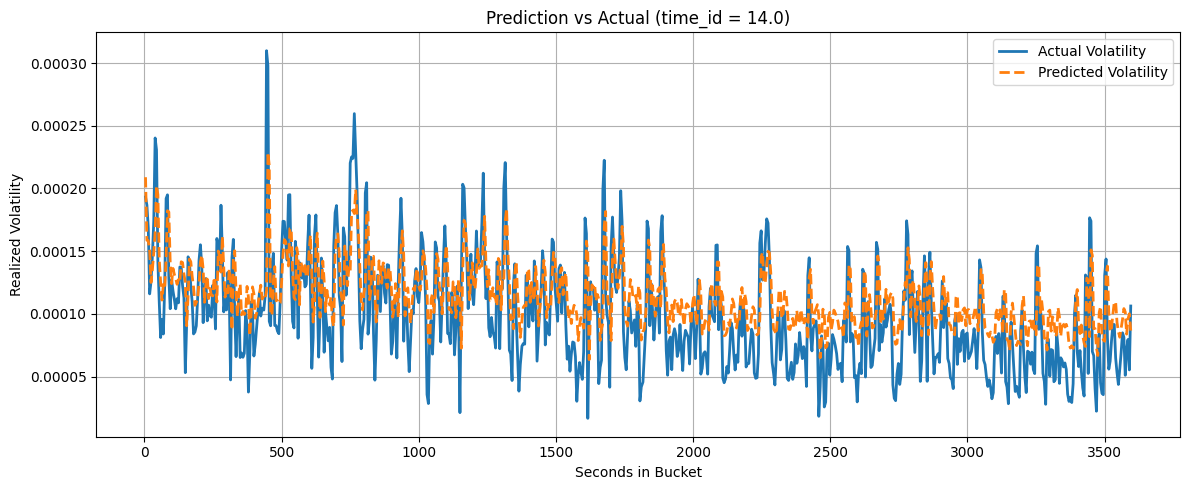

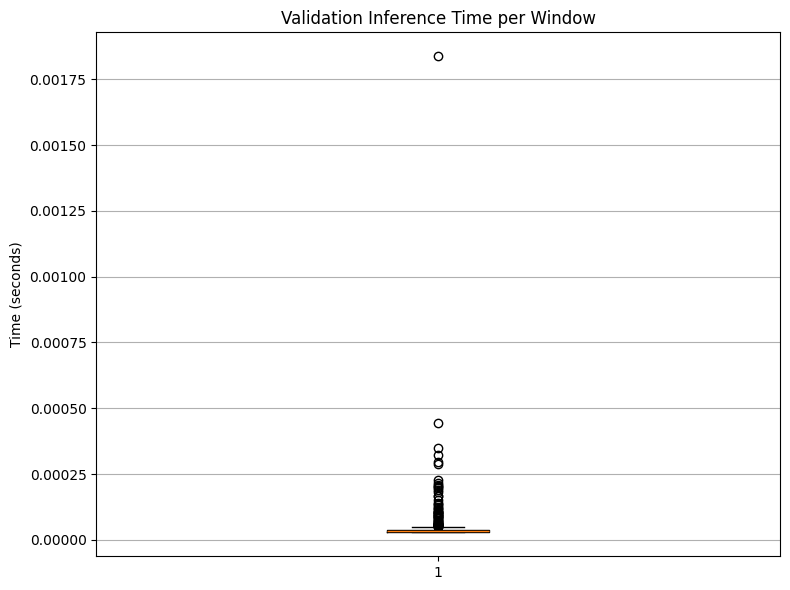

,time_id,start_time,y_true,y_pred,inference_time
0,14.0,4.0,0.000193,0.000209,0.000090
1,14.0,9.0,0.000187,0.000159,0.000064
2,14.0,14.0,0.000169,0.000158,0.000055
3,14.0,19.0,0.000116,0.000150,0.000053
4,14.0,24.0,0.000126,0.000125,0.000053
5,14.0,29.0,0.000146,0.000135,0.000052
6,14.0,34.0,0.000174,0.000149,0.000072
7,14.0,39.0,0.000240,0.000165,0.000051
8,14.0,44.0,0.000231,0.000202,0.000050
9,14.0,49.0,0.000141,0.000195,0.000050


In [ ]:
importlib.reload(rv)

model_rv_ols, test_df_ols = rv.ols(rolling_features_df)

# Plot predicted vs. actual volatility for one time_id
util.plot_prediction_vs_actual(
    df=test_df_ols,
    time_id=test_df_ols['time_id'].iloc[0],
    y_true_col='y_true',
    y_pred_col='y_pred'
)

util.plot_inference_time_boxplot(test_df_ols)

display(test_df_ols.head(10))

## LSTM

### LSTM Baseline

In [ ]:
importlib.reload(lstm)

# --- Run LSTM Baseline ---
model_lstm_baseline, history_lstm_baseline, val_df_lstm_baseline = lstm.baseline(
    snapshot_df=subset_snapshot_df,
    basic_features=['wap', 'log_return'],
    epochs=50,
    batch_size=32,
    learning_rate=1e-4,
    es_patience=10,
    lr_patience=5,
    model_name='baseline'
)

Epoch 1/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.9670 - val_loss: 0.8451 - learning_rate: 1.0000e-04
Epoch 2/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.9312 - val_loss: 0.9084 - learning_rate: 1.0000e-04
Epoch 3/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.8604 - val_loss: 0.7321 - learning_rate: 1.0000e-04
Epoch 4/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - loss: 0.8056 - val_loss: 0.5870 - learning_rate: 1.0000e-04
Epoch 5/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.7540 - val_loss: 0.5282 - learning_rate: 1.0000e-04
Epoch 6/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.7424 - val_loss: 0.5096 - learning_rate: 1.0000e-04
Epoch 7/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.7383 - val_loss: 0.5002 - learning_rate: 1.0000e-04
Epoch 8/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.7359 - val_loss: 0.4942 - learning_rate: 1.0000e-04
Epoch 9/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - loss: 0.7343 - val_loss: 

Validation MSE: 0.00000000
Validation RMSE: 0.00004232
Validation QLIKE: 0.3961
Directional Acc: 0.3657
Average inference time per window: 0.032856 seconds
Model & scalers saved to out/lstm


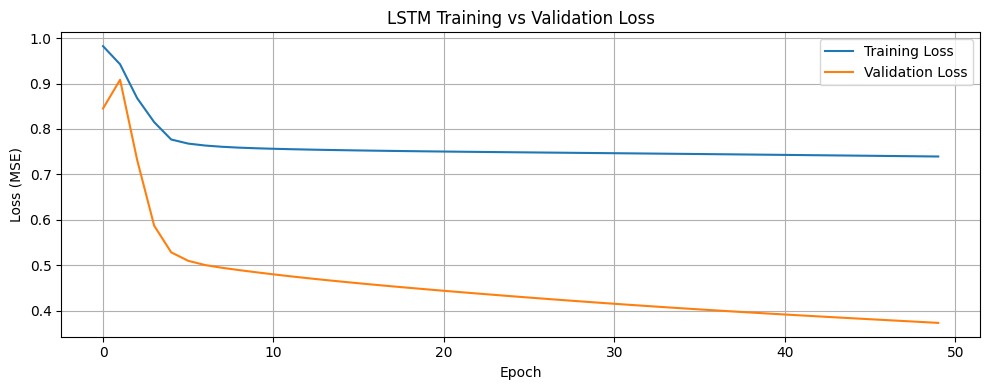

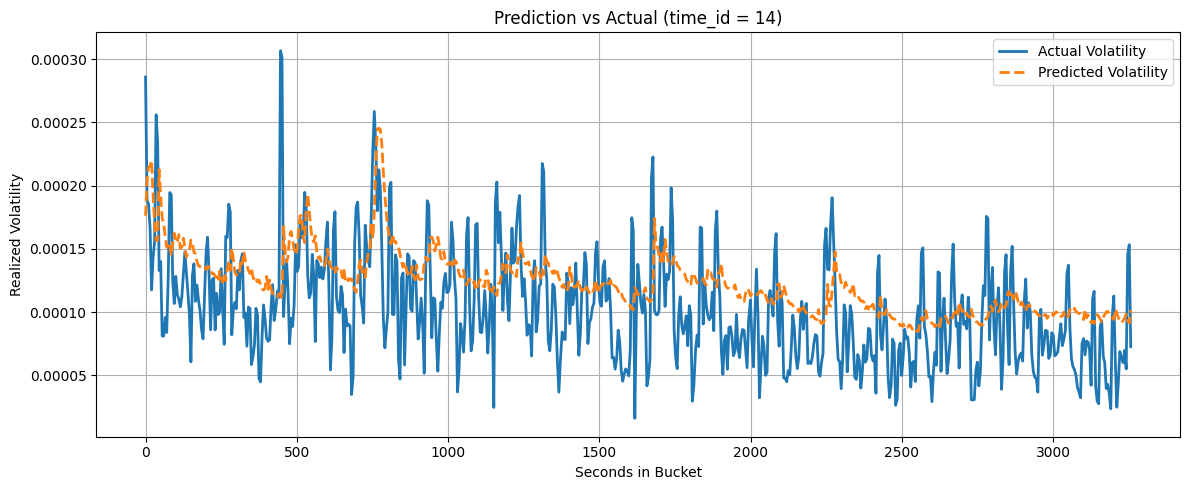

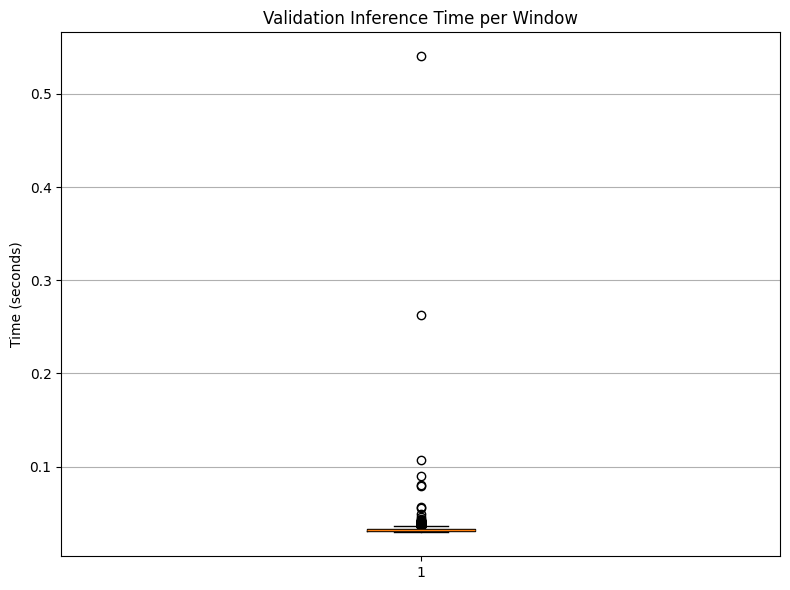

,time_id,start_time,y_true,y_pred,inference_time
0,14,0.0,0.000286,0.000176,0.540559
1,14,5.0,0.000188,0.000205,0.034921
2,14,10.0,0.000185,0.000214,0.035679
3,14,15.0,0.000166,0.000215,0.033417
4,14,20.0,0.000118,0.000220,0.032998
5,14,25.0,0.000144,0.000193,0.034423
6,14,30.0,0.000156,0.000170,0.032971
7,14,35.0,0.000256,0.000157,0.032453
8,14,40.0,0.000234,0.000157,0.034502
9,14,45.0,0.000133,0.000213,0.032566


In [ ]:
# --- Plot training loss ---
util.plot_training_loss(history_lstm_baseline)

# --- Plot prediction vs actual ---
util.plot_prediction_vs_actual(
    val_df_lstm_baseline,
    time_id=val_df_lstm_baseline['time_id'].iloc[1],
    y_true_col='y_true',
    y_pred_col='y_pred'
)

util.plot_inference_time_boxplot(val_df_lstm_baseline)

display(val_df_lstm_baseline.head(10))

### LSTM With Features

In [ ]:
importlib.reload(lstm)

feature_cols = ["wap", "spread_pct", "imbalance", "depth_ratio", "log_return",
                "log_wap_change", "rolling_std_logret", "spread_zscore", "volume_imbalance"]

# --- Run LSTM Baseline ---
model_lstm_features, history_lstm_features, val_df_lstm_features = lstm.baseline(
    snapshot_df=subset_snapshot_df,
    basic_features=feature_cols,
    epochs=50,
    batch_size=32,
    learning_rate=1e-4,
    es_patience=10,
    lr_patience=5,
    model_name='additional_features'
)

Epoch 1/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.9404 - val_loss: 0.5201 - learning_rate: 1.0000e-04
Epoch 2/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.8318 - val_loss: 0.3994 - learning_rate: 1.0000e-04
Epoch 3/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.8099 - val_loss: 0.3670 - learning_rate: 1.0000e-04
Epoch 4/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.7932 - val_loss: 0.3453 - learning_rate: 1.0000e-04
Epoch 5/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 32ms/step - loss: 0.7775 - val_loss: 0.3409 - learning_rate: 1.0000e-04
Epoch 6/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.7675 - val_loss: 0.3467 - learning_rate: 1.0000e-04
Epoch 7/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.7612 - val_loss: 0.3495 - learning_rate: 1.0000e-04
Epoch 8/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.7558 - val_loss: 0.3521 - learning_rate: 1.0000e-04
Epoch 9/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 5s 31ms/step - loss: 0.7506 - val_loss: 

Validation MSE: 0.00000000
Validation RMSE: 0.00004046
Validation QLIKE: 0.3822
Directional Acc: 0.4228
Average inference time per window: 0.032021 seconds
Model & scalers saved to out/lstm


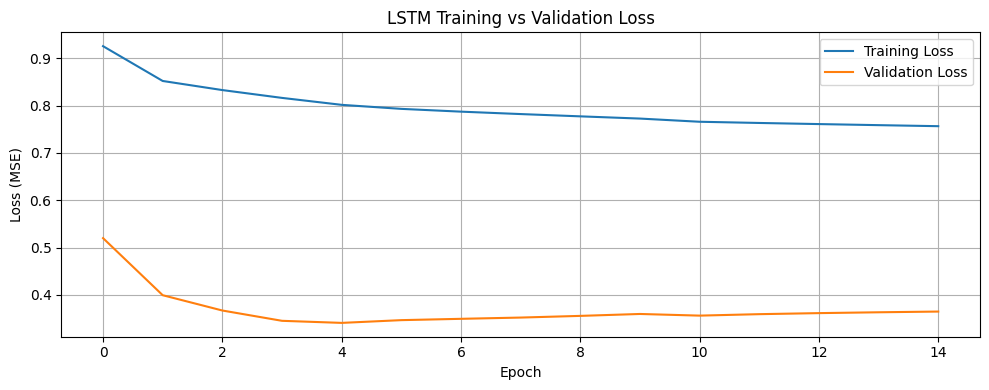

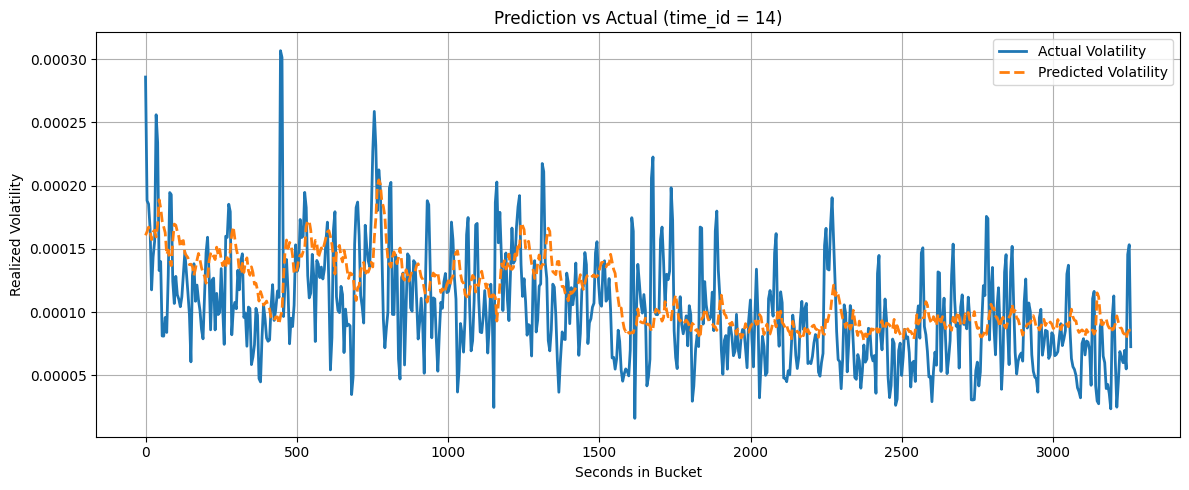

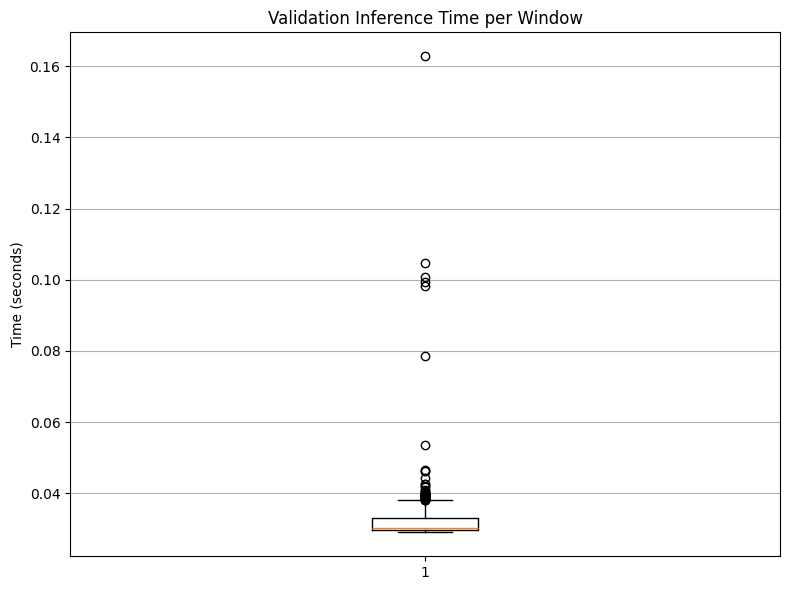

,time_id,start_time,y_true,y_pred,inference_time
0,14,0.0,0.000286,0.000161,0.104821
1,14,5.0,0.000188,0.000164,0.035891
2,14,10.0,0.000185,0.000167,0.035220
3,14,15.0,0.000166,0.000164,0.035258
4,14,20.0,0.000118,0.000157,0.037052
5,14,25.0,0.000144,0.000163,0.035133
6,14,30.0,0.000156,0.000165,0.035833
7,14,35.0,0.000256,0.000159,0.035038
8,14,40.0,0.000234,0.000169,0.038045
9,14,45.0,0.000133,0.000189,0.036456


In [ ]:
# --- Plot training loss ---
util.plot_training_loss(history_lstm_features)

# --- Plot prediction vs actual ---
util.plot_prediction_vs_actual(
    val_df_lstm_features,
    time_id=val_df_lstm_features['time_id'].iloc[1],
    y_true_col='y_true',
    y_pred_col='y_pred'
)

util.plot_inference_time_boxplot(val_df_lstm_features)

display(val_df_lstm_features.head(10))

## Advanced LSTM Model

In [ ]:
importlib.reload(lstm)

feature_cols = ["wap", "spread_pct", "imbalance", "depth_ratio", "log_return",
                "log_wap_change", "rolling_std_logret", "spread_zscore", "volume_imbalance"]

model_lstm_advanced, history_lstm_advanced, val_df_lstm_advanced = lstm.advanced(
    subset_snapshot_df,
    basic_features=feature_cols,
    epochs=50,
    batch_size=32,
    model_name='advanced'
)

Epoch 1/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 40s 221ms/step - loss: 0.9337 - val_loss: 0.5344 - learning_rate: 1.0000e-04
Epoch 2/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 36s 219ms/step - loss: 0.9812 - val_loss: 0.6718 - learning_rate: 1.0000e-04
Epoch 3/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 36s 219ms/step - loss: 1.3151 - val_loss: 0.9286 - learning_rate: 1.0000e-04
Epoch 4/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 36s 219ms/step - loss: 1.2305 - val_loss: 0.6662 - learning_rate: 1.0000e-04
Epoch 5/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 36s 220ms/step - loss: 1.1969 - val_loss: 0.5519 - learning_rate: 1.0000e-04
Epoch 6/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 36s 218ms/step - loss: 1.1402 - val_loss: 0.6262 - learning_rate: 1.0000e-04
Epoch 7/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 36s 222ms/step - loss: 1.1482 - val_loss: 0.6520 - learning_rate: 1.0000e-04
Epoch 8/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 35s 215ms/step - loss: 1.0906 - val_loss: 0.6414 - learning_rate: 1.0000e-04
Epoch 9/50
164/164 ━━━━━━━━━━━━━━━━━━━━ 37s 223ms/step - loss: 1

Final Model MSE: 0.00000000
Final Model RMSE: 0.00005066
Final Model QLIKE: 0.5020
Directional Acc: 0.4699
Avg Inference Time: 0.061351s
Saved final model & scalers to <KerasTensor shape=(None, 1), dtype=float32, sparse=False, ragged=False, name=keras_tensor_30>


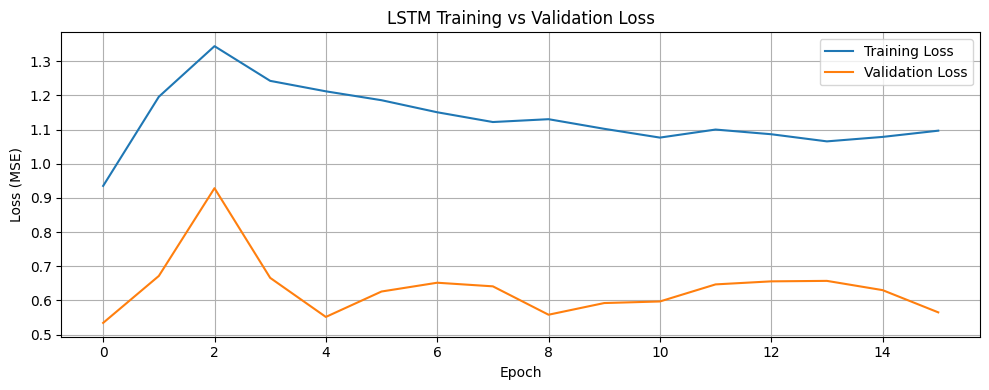

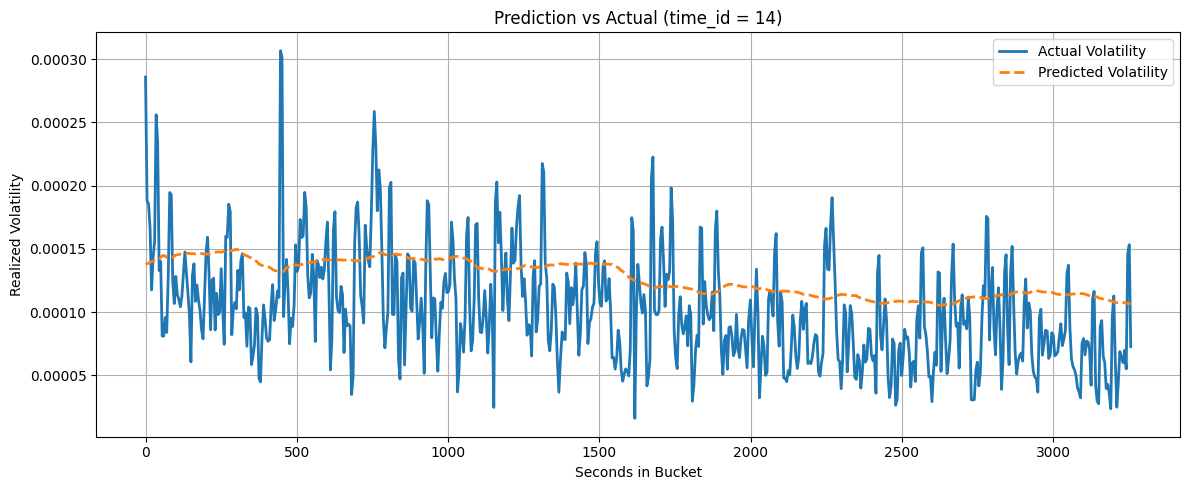

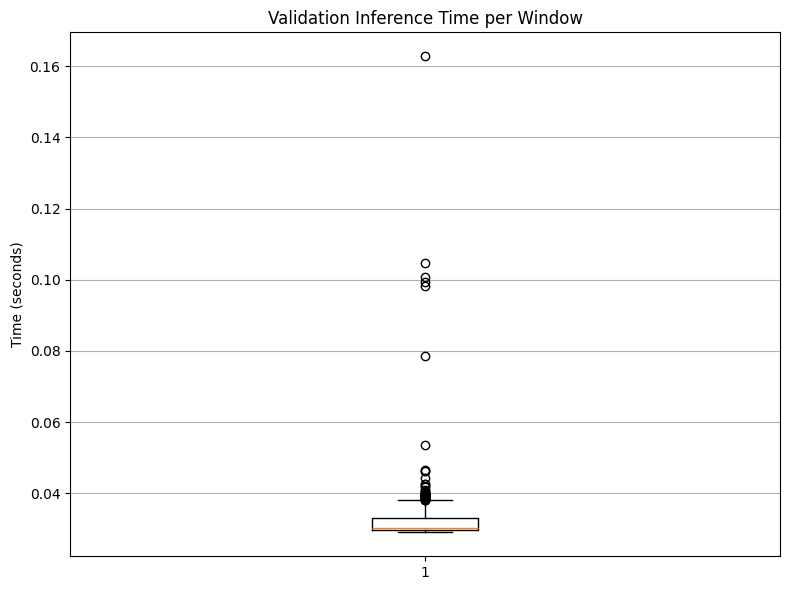

In [ ]:
# --- Plot training loss ---
util.plot_training_loss(history_lstm_advanced)

# --- Plot prediction vs actual ---
util.plot_prediction_vs_actual(
    val_df_lstm_advanced,
    time_id=val_df_lstm_advanced['time_id'].iloc[1],
    y_true_col='y_true',
    y_pred_col='y_pred'
)

util.plot_inference_time_boxplot(val_df_lstm_features)

## In Sample Evaluation

                      model           mse      rmse     qlike  \
0              ols_baseline  1.285060e-09  0.000036  0.322214   
1             lstm_baseline  1.791092e-09  0.000042  0.396131   
2  lstm_additional_features  1.637124e-09  0.000040  0.382185   
3             lstm_advanced  2.566615e-09  0.000051  0.501960   

   directional_accuracy  avg_inference_time  
0              0.517975            0.000040  
1              0.365741            0.032856  
2              0.422840            0.032021  
3              0.469907            0.061351  


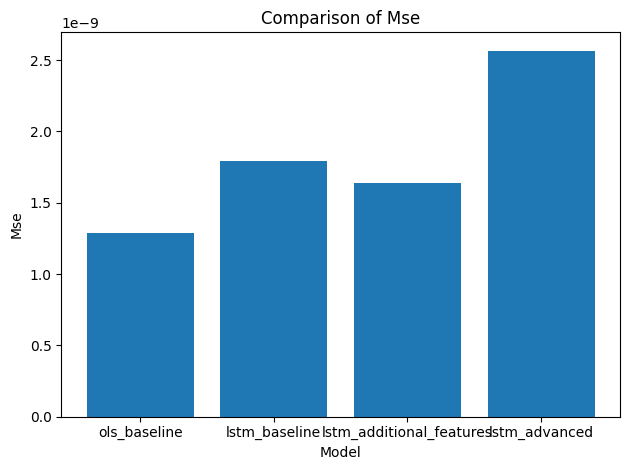

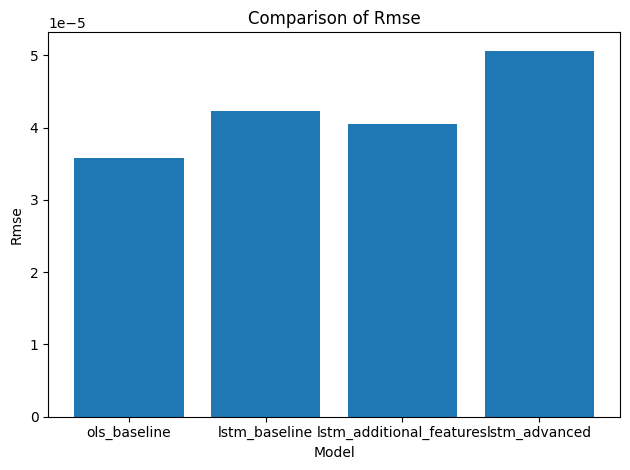

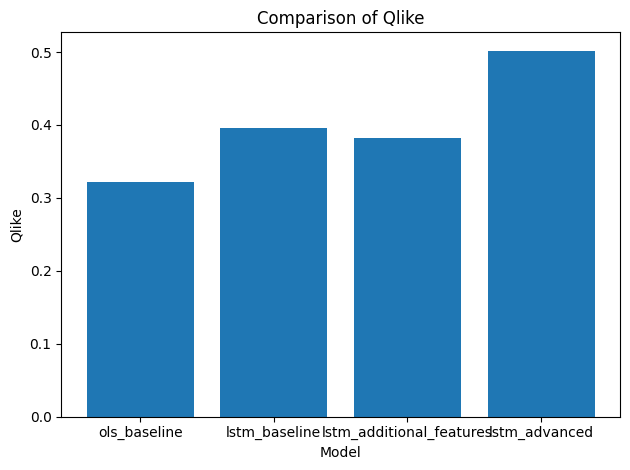

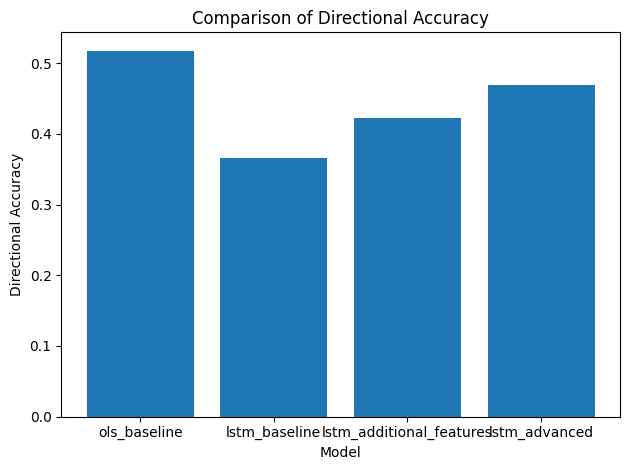

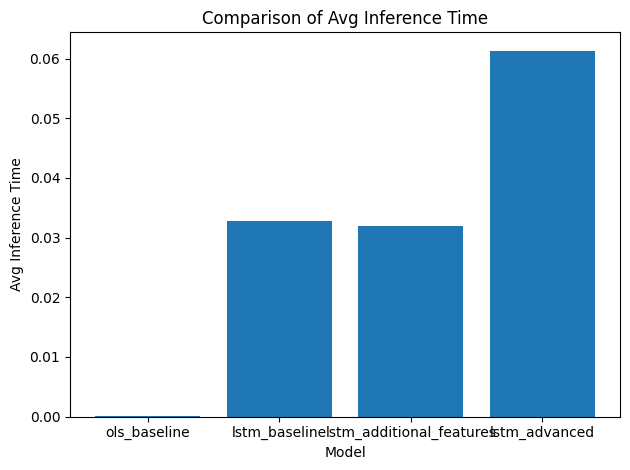

In [ ]:
metrics = []
for name, val_df in [
        ('ols_baseline', test_df_ols),
        ('lstm_baseline', val_df_lstm_baseline),
        ('lstm_additional_features', val_df_lstm_features),
        ('lstm_advanced', val_df_lstm_advanced)
    ]:
    y_true = val_df['y_true'].values
    y_pred = val_df['y_pred'].values
    mse = np.mean((y_true - y_pred) ** 2)
    rmse = np.sqrt(mse)
    qlike = util.qlike_loss(y_true, y_pred)
    directional_acc = util.directional_accuracy(y_true, y_pred)
    avg_inf_time = val_df['inference_time'].mean()
    metrics.append({
        'model': name,
        'mse': mse,
        'rmse': rmse,
        'qlike': qlike,
        'directional_accuracy': directional_acc,
        'avg_inference_time': avg_inf_time
    })

metric_df = pd.DataFrame(metrics)
print(metric_df)

# -------------------------------------------------------------
## Evaluation Metrics
# -------------------------------------------------------------
# Visualise each metric in its own bar chart

# List of metrics to plot (excluding model name)
plot_metrics = ['mse', 'rmse', 'qlike', 'directional_accuracy', 'avg_inference_time']

for metric in plot_metrics:
    plt.figure()
    plt.bar(metric_df['model'], metric_df[metric])
    plt.title(f'Comparison of {metric.replace("_", " ").title()}')
    plt.ylabel(metric.replace("_", " ").title())
    plt.xlabel('Model')
    plt.xticks(rotation=0)
    plt.tight_layout()
    plt.show()

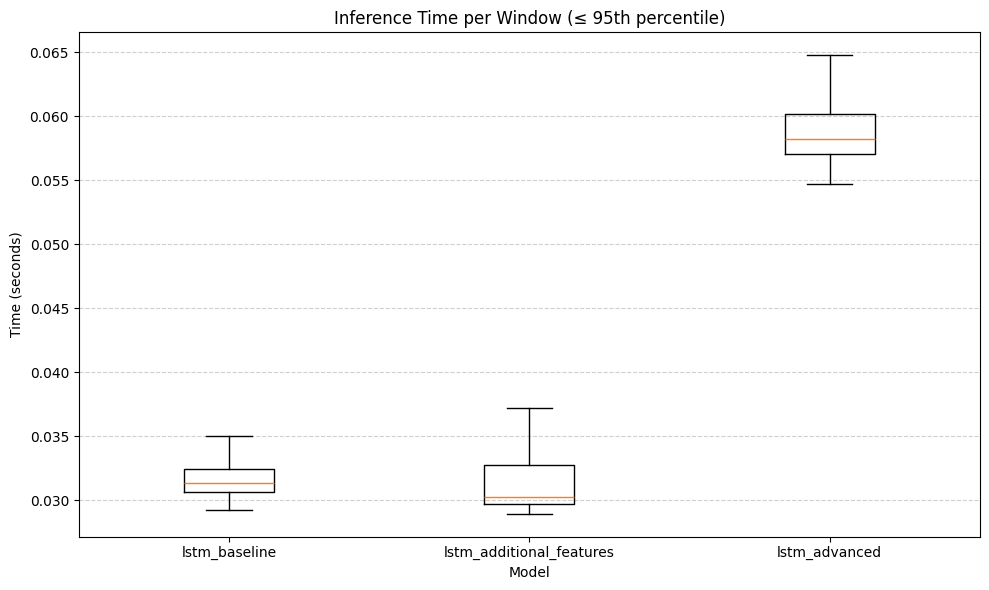

In [ ]:
# Create a dictionary of DataFrames for each model
val_dfs = {
    'lstm_baseline': val_df_lstm_baseline,
    'lstm_additional_features': val_df_lstm_features,
    'lstm_advanced': val_df_lstm_advanced
}

util.plot_side_by_side_inference_boxplots(val_dfs,
                                     inference_col='inference_time',
                                     percentile=95)

## Out of Sample Evaluation

### Highly Correlated Stocks: ID-104919

In [ ]:
folder_path = "data"
feature_path = os.path.join(folder_path, "order_book_feature.parquet")
target_path = os.path.join(folder_path, "order_book_target.parquet")

feature_df = pd.read_parquet(feature_path, engine='pyarrow')
target_df = pd.read_parquet(target_path, engine='pyarrow')
combined_df = pd.concat([feature_df, target_df], axis=0)
combined_df = combined_df.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

df_high_cor_stock = combined_df[combined_df["stock_id"] == 104919].copy()

snapshot_features_df_high_cor = util.create_snapshot_features(df_high_cor_stock)
snapshot_features_df_high_cor = snapshot_features_df_high_cor.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

subset_time_ids = snapshot_features_df_high_cor['time_id'].unique()[:10]
subset_snapshot_df_high_cor = snapshot_features_df[snapshot_features_df_high_cor['time_id'].isin(subset_time_ids)].copy()

In [ ]:
model_path  = 'out/lstm/advanced.h5'
scaler_path = 'out/lstm/advanced_scalers.pkl'

basic_features = ["wap", "spread_pct", "imbalance",
                  "depth_ratio", "log_return", "log_wap_change",
                  "rolling_std_logret", "spread_zscore",
                  "volume_imbalance"]

val_df_oos_high_cor, oos_metrics_high_cor = util.out_of_sample_evaluation(
    model_path, scaler_path,
    subset_snapshot_df_high_cor,
    feature_cols=basic_features
)

print("Out-of-Sample Metrics:", oos_metrics_high_cor)
print(val_df_oos_high_cor.head())


Out-of-Sample Metrics: {'mse': 3.276007473664776e-08, 'rmse': 0.00018099744400584158, 'qlike': 4.183757792128442, 'directional_accuracy': 0.519361833952912, 'avg_inference_time': 0.06196931018536619}
   time_id  start_time    y_true    y_pred  inference_time
0        6      1800.0  0.000185  0.000106        0.398865
1        6      1802.0  0.000129  0.000106        0.063055
2        6      1805.0  0.000329  0.000106        0.062352
3        6      1807.0  0.000446  0.000105        0.062805
4        6      1810.0  0.000438  0.000106        0.058524


### Lowly Correlated Stocks: ID-22753

In [ ]:
folder_path = "data"
feature_path = os.path.join(folder_path, "order_book_feature.parquet")
target_path = os.path.join(folder_path, "order_book_target.parquet")

feature_df = pd.read_parquet(feature_path, engine='pyarrow')
target_df = pd.read_parquet(target_path, engine='pyarrow')
combined_df = pd.concat([feature_df, target_df], axis=0)
combined_df = combined_df.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

df_low_cor_stock = combined_df[combined_df["stock_id"] == 22753].copy()

snapshot_features_df_low_cor = util.create_snapshot_features(df_low_cor_stock)
snapshot_features_df_low_cor = snapshot_features_df_low_cor.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

subset_time_ids = snapshot_features_df_low_cor['time_id'].unique()[:10]
subset_snapshot_df_low_cor = snapshot_features_df_low_cor[snapshot_features_df_low_cor['time_id'].isin(subset_time_ids)].copy()

In [ ]:
model_path  = 'out/lstm/advanced.h5'
scaler_path = 'out/lstm/advanced_scalers.pkl'
basic_features = ["wap", "spread_pct", "imbalance",
                  "depth_ratio", "log_return", "log_wap_change",
                  "rolling_std_logret", "spread_zscore",
                  "volume_imbalance"]

val_df_oos_low_cor, oos_metrics_low_cor = util.out_of_sample_evaluation(
    model_path, scaler_path,
    subset_snapshot_df_low_cor,
    feature_cols=basic_features
)

print("Out-of-Sample Metrics:", oos_metrics_low_cor)
print(val_df_oos_low_cor.head())

Out-of-Sample Metrics: {'mse': 3.320566820245771e-08, 'rmse': 0.00018222422507026257, 'qlike': 4.236690438652568, 'directional_accuracy': 0.5194151096669375, 'avg_inference_time': 0.0564814600901018}
   time_id  start_time    y_true    y_pred  inference_time
0        6      1800.0  0.000185  0.000106        0.338168
1        6      1802.0  0.000129  0.000106        0.056722
2        6      1805.0  0.000329  0.000106        0.056631
3        6      1807.0  0.000446  0.000105        0.056182
4        6      1810.0  0.000438  0.000106        0.056672


In [ ]:
insample_adv = metric_df.loc[metric_df['model'] == 'lstm_advanced'].iloc[0].to_dict()

comparison_df = pd.DataFrame([
    {'dataset': 'in_sample',             **insample_adv},
    {'dataset': 'out_sample_highcor',   **oos_metrics_high_cor},
    {'dataset': 'out_sample_lowcor',    **oos_metrics_low_cor},
]).set_index('dataset')

display(comparison_df)


,model,mse,rmse,qlike,directional_accuracy,avg_inference_time
dataset,,,,,,
in_sample,lstm_advanced,2.566615e-09,0.000051,0.501960,0.469907,0.061351
out_sample_highcor,NaN,3.276007e-08,0.000181,4.183758,0.519362,0.061969
out_sample_lowcor,NaN,3.320567e-08,0.000182,4.236690,0.519415,0.056481


# Pipeline 2: Predicting Bid-Ask Spread and Quoting Strategy

**1. Data Preparation:** Our data is prepared by using our Pipeline 1's LSTM code to predict volatility values. Then we divide the data into 330s time buckets and merge predicted volatility (***at time t+1***) with features like "wap", "spread_pct", "imbalance", "depth_ratio", "log_return", "bid_ask_spread" (***at time t***). For our dataset for prediction, we shift "bid_ask_spread" by 1 row to simulate time t+1.

**2. BAS Model Prediction:** We utilize xgBoost model to train, using 80/20 split and GridSearchCV to find the best combination of parameters for the job,

**3. Mid Price Prediction:** We used a simple linear regression model to predict the approximate mid price

**4. Quoting Strategy and Evaluation:** Then suggested quoting strategy is simple: Bid/Ask = Mid Price -/+ BAS/2. We evaluated the performance of our strategy. See the evaluation tactic below at section "Trading at Predicted Quoting Prices vs Actual Prices"

## Data Preperation

In [ ]:
# Set path to local data directory
folder_path = "data"
feature_path = os.path.join(folder_path, "order_book_feature.parquet")
target_path = os.path.join(folder_path, "order_book_target.parquet")

# Load and combine parquet files
feature_df = pd.read_parquet(feature_path, engine='pyarrow')
target_df = pd.read_parquet(target_path, engine='pyarrow')
combined_df = pd.concat([feature_df, target_df], axis=0)
combined_df = combined_df.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

# Filter one stock for now
df_single_stock = combined_df[combined_df["stock_id"] == 50200].copy()

# Step 1: Compute snapshot features
snapshot_features_df = util.create_snapshot_features(df_single_stock)
snapshot_features_df = snapshot_features_df.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

subset_time_ids = snapshot_features_df['time_id'].unique()
subset_snapshot_df = snapshot_features_df[snapshot_features_df['time_id'].isin(subset_time_ids)].copy()

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model

# --- Load model and scaler ---
model = load_model("out/lstm/moe_full.h5", custom_objects={"mse": "mse"})
scaler = joblib.load("out/lstm/moe_scalers_full.pkl")
x_scaler = scaler["x_scaler"]

# --- Define features used by LSTM ---
basic_features = ["wap", "spread_pct", "imbalance",
                  "depth_ratio", "log_return", "log_wap_change",
                  "rolling_std_logret", "spread_zscore", "volume_imbalance"]

# --- Group by time_id and bucket into 330s chunks ---
subset_snapshot_df["bucket_id_330s"] = subset_snapshot_df["seconds_in_bucket"] // 330

# Collect predictions
predictions = []

# Iterate over time_id + bucket_id_330s
grouped = subset_snapshot_df.groupby(['time_id', 'bucket_id_330s'])

for (time_id, bucket), group in grouped:
    if len(group) < 330:
        continue  # Skip if not enough steps for LSTM

    X = group[basic_features].values[-330:]  # Last 330 rows
    X_scaled = x_scaler.transform(X)
    X_reshaped = X_scaled.reshape(1, 330, len(basic_features))

    y_pred = model.predict(X_reshaped, verbose=0)[0][0]

    predictions.append({
        'time_id': time_id,
        'bucket_id_330s': bucket,
        'predicted_value': y_pred
    })

# --- Create DataFrame of results ---
pred_df = pd.DataFrame(predictions)
pred_df.to_csv("predictions_spy.csv", index=False)
print(pred_df.head())


   time_id  bucket_id_330s predicted_value
0        6             5.0     [1.4227135]
1        6             6.0   [-0.47987074]
2        6             7.0   [-0.34094492]
3        6             8.0   [-0.04093212]
4        6             9.0     [0.7414936]


In [ ]:
pred_df = pd.read_csv("predictions_qqq.csv")
pred_df.head(13)

,time_id,bucket_id_330s,predicted_value
0,6,5.0,[1.7991956]
1,6,6.0,[1.5947386]
2,6,7.0,[1.3377694]
3,6,8.0,[2.611164]
4,6,9.0,[2.2375145]
5,6,10.0,[2.739195]
6,7,5.0,[1.9307884]
7,7,6.0,[1.7067051]
8,7,7.0,[1.4506783]
9,7,8.0,[1.1368325]


: 

## BAS Prediction Model using XGBoost

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import joblib

if os.path.exists("predictions_spy.csv"):
    pred_df = pd.read_csv("predictions_spy.csv")

pred_df['predicted_value'] = pred_df['predicted_value'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else x)
pred_df['predicted_value'] = pd.to_numeric(pred_df['predicted_value'], errors='coerce')

# --- Step 0: Compute realized volatility ---
subset_snapshot_df['log_return_squared'] = subset_snapshot_df['log_return'] ** 2
rv_df = subset_snapshot_df.groupby("time_id")['log_return_squared'].sum().reset_index()
rv_df['realized_volatility'] = np.sqrt(rv_df['log_return_squared'])
rv_df = rv_df.drop(columns='log_return_squared')

# --- Step 1: Aggregate data into 330s buckets ---
subset_snapshot_df['bucket_id_330s'] = subset_snapshot_df['seconds_in_bucket'] // 330
agg_df = subset_snapshot_df.groupby(['time_id', 'bucket_id_330s']).agg({
    "wap": "mean",  
    "spread_pct": "mean",
    "imbalance": "mean",
    "depth_ratio": "mean",
    "log_return": "mean",
    "bid_ask_spread": "mean"
}).reset_index()
agg_df['bid_ask_spread_lead1'] = agg_df.groupby('time_id')['bid_ask_spread'].shift(-1)
agg_df = agg_df.dropna(subset=['bid_ask_spread_lead1']).reset_index(drop=True)

# --- Step 2: Merge realized volatility + LSTM predictions ---
pred_df = pred_df.rename(columns={"predicted_value": "predicted_volatility_lead1"})
agg_df = agg_df.merge(rv_df, on='time_id', how='left')
merged_df = pd.merge(pred_df, agg_df, on=['time_id', 'bucket_id_330s'], how='inner')

# --- Step 3: Prepare features and target ---
X = merged_df.drop(columns=["time_id", "bucket_id_330s"])
y = merged_df["bid_ask_spread_lead1"]

cutoff = int(len(merged_df) * 0.8)
X_train = X.iloc[:cutoff].copy()
y_train = y.iloc[:cutoff]
X_test = X.iloc[cutoff:].copy()
y_test = y.iloc[cutoff:]

# --- Step 4: Scale selected features ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[['spread_pct', 'realized_volatility']])
X_train[['spread_pct_scaled', 'realized_volatility_scaled']] = X_train_scaled

X_test_scaled = scaler.transform(X_test[['spread_pct', 'realized_volatility']])
X_test[['spread_pct_scaled', 'realized_volatility_scaled']] = X_test_scaled

# --- Step 5: Final feature selection ---
feature_cols = ['predicted_volatility_lead1', 'spread_pct_scaled', 'realized_volatility_scaled',
                'wap', 'imbalance', 'depth_ratio', 'log_return', 'bid_ask_spread']
X_train_final = X_train[feature_cols]
X_test_final = X_test[feature_cols]
y_train_final = X_train['bid_ask_spread_lead1']
y_test_final = X_test['bid_ask_spread_lead1']

# --- Step 6: Train model ---
if X_train_final.empty or X_test_final.empty:
    print("Training or test set is empty after split.")
else:
    param_grid = {
        'n_estimators': [100, 300, 500],
        'max_depth': [5, 6, 7, 8],
        'learning_rate': [0.01, 0.05, 0.1],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'gamma': [0, 1, 5],
        'reg_alpha': [0, 0.1, 1],
        'reg_lambda': [0.5, 1, 5, 10]
    }

    xgb_reg = XGBRegressor(random_state=42, objective='reg:squarederror')
    cv_folds = min(5, len(X_train_final)) if len(X_train_final) > 1 else 2

    grid_search = GridSearchCV(xgb_reg, param_grid, cv=cv_folds, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
    grid_search.fit(X_train_final, y_train_final)
    best_model = grid_search.best_estimator_
    print("Best parameters found:", grid_search.best_params_)

    y_pred_best = best_model.predict(X_test_final)

    print(f"MSE: {mean_squared_error(y_test_final, y_pred_best):.6f}")
    print(f"MAE: {mean_absolute_error(y_test_final, y_pred_best):.6f}")
    print(f"RMSE: {np.sqrt(mean_squared_error(y_test_final, y_pred_best)):.6f}")
    print(f"R²: {r2_score(y_test_final, y_pred_best):.4f}")

    joblib.dump(best_model, "bid_ask_spread_model.pkl")

    # --- Step 7: Evaluation DataFrame ---
    comparison_df_best = pd.DataFrame({
        "time_id": merged_df.loc[y_test_final.index, "time_id"].values,
        "bucket_id_330s": merged_df.loc[y_test_final.index, "bucket_id_330s"].values,
        "actual_bid_ask_spread": y_test_final.values,
        "predicted_bid_ask_spread": y_pred_best
    })

    print(comparison_df_best.head())


Fitting 5 folds for each of 11664 candidates, totalling 58320 fits
Best parameters found: {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 7, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 0.5, 'subsample': 0.6}
MSE: 0.000001
MAE: 0.000540
RMSE: 0.000782
R²: 0.6987
   time_id  bucket_id_330s  actual_bid_ask_spread  predicted_bid_ask_spread
0      973             3.0               0.012030                  0.011816
1      973             4.0               0.012242                  0.012273
2      973             5.0               0.011848                  0.012040
3      973             6.0               0.012182                  0.011937
4      973             7.0               0.011364                  0.012149


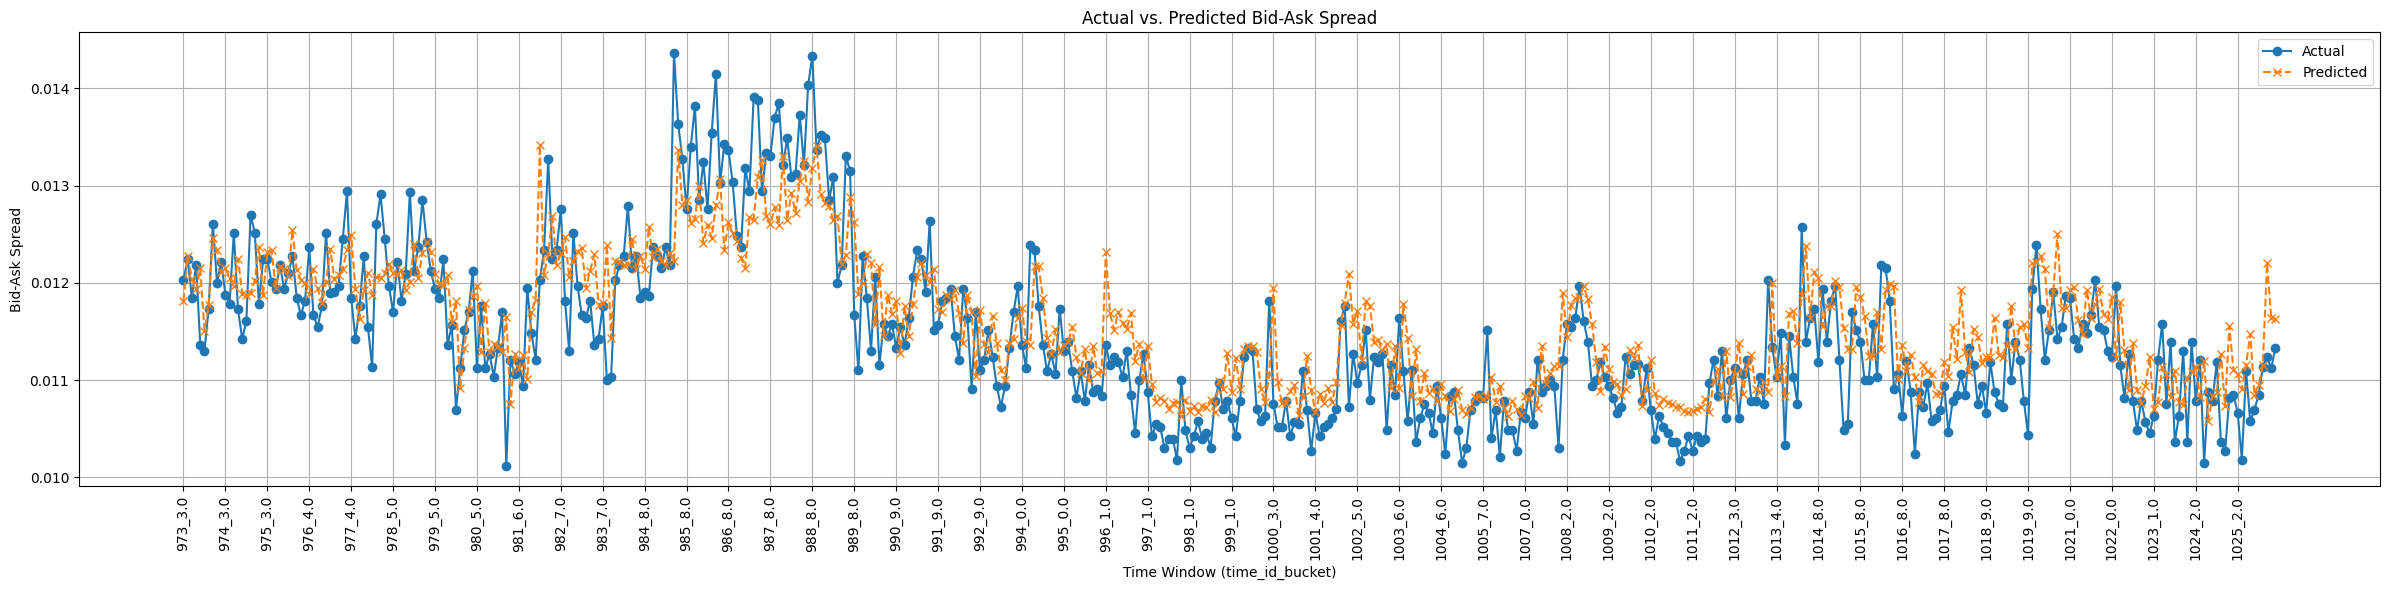

In [ ]:
import matplotlib.pyplot as plt

# Slice first 500 rows
subset = comparison_df_best.head(500).copy()

if 'window_label' not in subset.columns:
    subset['window_label'] = subset['time_id'].astype(str) + '_' + subset['bucket_id_330s'].astype(str)

# Plot
plt.figure(figsize=(24, 6))
plt.plot(subset['window_label'], subset['actual_bid_ask_spread'], label='Actual', marker='o')
plt.plot(subset['window_label'], subset['predicted_bid_ask_spread'], label='Predicted', marker='x', linestyle='--')

plt.title("Actual vs. Predicted Bid-Ask Spread")
plt.xlabel("Time Window (time_id_bucket)")
plt.ylabel("Bid-Ask Spread")
plt.xticks(ticks=np.arange(0, len(subset), 10), labels=subset['window_label'][::10], rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Evaluation

In [ ]:
# XGBoost predictions
y_pred_best = best_model.predict(X_test_final)

# Actual values
y_true = y_test_final

baseline_pred = X_test['bid_ask_spread'].values

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# XGBoost performance
mse_xgb = mean_squared_error(y_true, y_pred_best)
mae_xgb = mean_absolute_error(y_true, y_pred_best)
rmse_xgb = np.sqrt(mse_xgb)
r2_xgb = r2_score(y_true, y_pred_best)

# Baseline performance
mse_baseline = mean_squared_error(y_true, baseline_pred)
mae_baseline = mean_absolute_error(y_true, baseline_pred)
rmse_baseline = np.sqrt(mse_baseline)
r2_baseline = r2_score(y_true, baseline_pred)

# Print comparison
print("\nModel Performance Comparison:")
print("------------------------------------------------------")
print(f"{'Metric':<10} | {'XGBoost':>10} | {'Baseline':>10}")
print("------------------------------------------------------")
print(f"{'MSE':<10} | {mse_xgb:10.6f} | {mse_baseline:10.6f}")
print(f"{'MAE':<10} | {mae_xgb:10.6f} | {mae_baseline:10.6f}")
print(f"{'RMSE':<10} | {rmse_xgb:10.6f} | {rmse_baseline:10.6f}")
print(f"{'R²':<10} | {r2_xgb:10.4f} | {r2_baseline:10.4f}")



Model Performance Comparison:
------------------------------------------------------
Metric     |    XGBoost |   Baseline
------------------------------------------------------
MSE        |   0.000001 |   0.000000
MAE        |   0.000540 |   0.000451
RMSE       |   0.000782 |   0.000604
R²         |     0.6987 |     0.8202


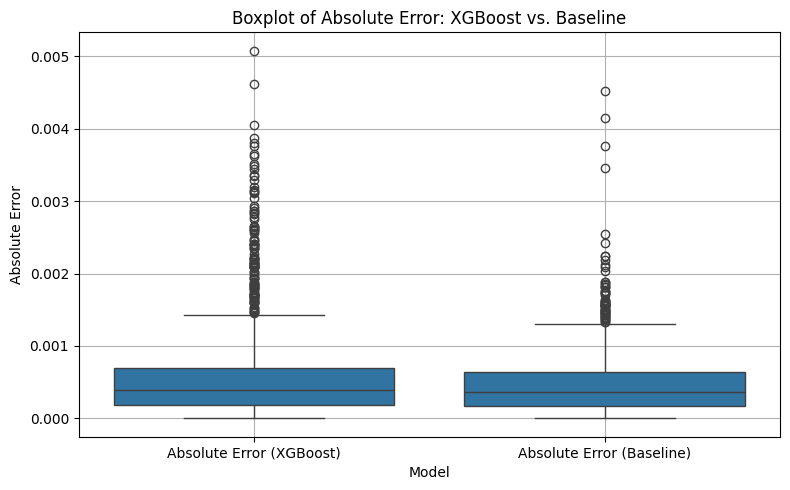

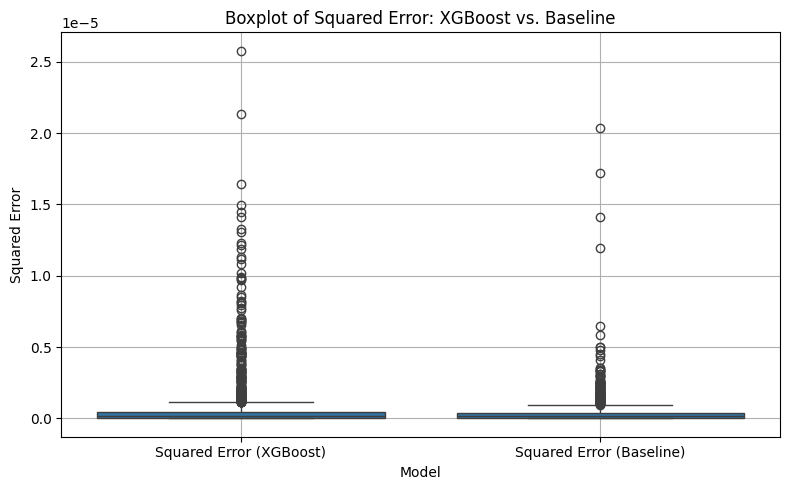

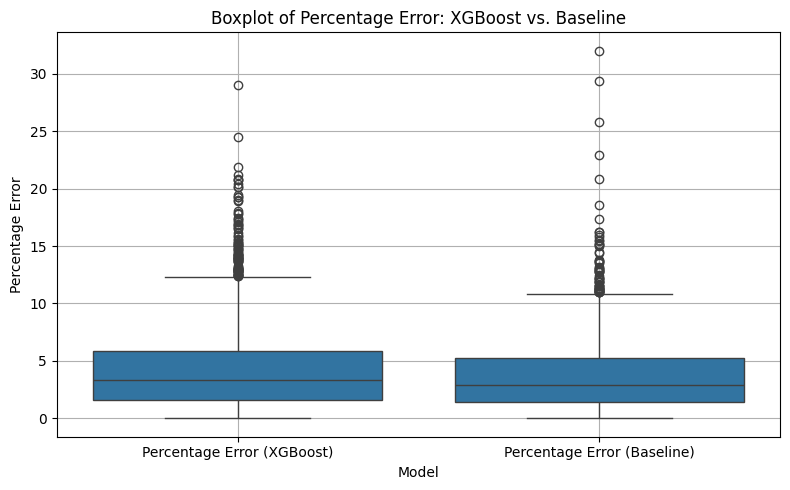

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Ensure arrays are NumPy arrays
y_true = np.array(y_test_final)
y_pred_best = np.array(y_pred_best)
baseline_pred = np.array(X_test['bid_ask_spread'].values)

# --- Create DataFrame of error metrics ---
metrics_df = pd.DataFrame({
    "Absolute Error (XGBoost)": np.abs(y_true - y_pred_best),
    "Absolute Error (Baseline)": np.abs(y_true - baseline_pred),
    "Squared Error (XGBoost)": (y_true - y_pred_best) ** 2,
    "Squared Error (Baseline)": (y_true - baseline_pred) ** 2,
    "Percentage Error (XGBoost)": np.abs((y_true - y_pred_best) / y_true) * 100,
    "Percentage Error (Baseline)": np.abs((y_true - baseline_pred) / y_true) * 100,
})

# --- Melt DataFrame for Seaborn boxplot ---
melted_abs = metrics_df[["Absolute Error (XGBoost)", "Absolute Error (Baseline)"]].melt(
    var_name="Model", value_name="Absolute Error"
)

melted_sq = metrics_df[["Squared Error (XGBoost)", "Squared Error (Baseline)"]].melt(
    var_name="Model", value_name="Squared Error"
)

melted_pct = metrics_df[["Percentage Error (XGBoost)", "Percentage Error (Baseline)"]].melt(
    var_name="Model", value_name="Percentage Error"
)

# --- Plot Absolute Error ---
plt.figure(figsize=(8, 5))
sns.boxplot(x="Model", y="Absolute Error", data=melted_abs)
plt.title("Boxplot of Absolute Error: XGBoost vs. Baseline")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot Squared Error ---
plt.figure(figsize=(8, 5))
sns.boxplot(x="Model", y="Squared Error", data=melted_sq)
plt.title("Boxplot of Squared Error: XGBoost vs. Baseline")
plt.grid(True)
plt.tight_layout()
plt.show()

# --- Plot Percentage Error (optional, skip if y_true has zeros) ---
if not np.any(y_true == 0):
    plt.figure(figsize=(8, 5))
    sns.boxplot(x="Model", y="Percentage Error", data=melted_pct)
    plt.title("Boxplot of Percentage Error: XGBoost vs. Baseline")
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Skipped percentage error boxplot due to division by zero risk.")


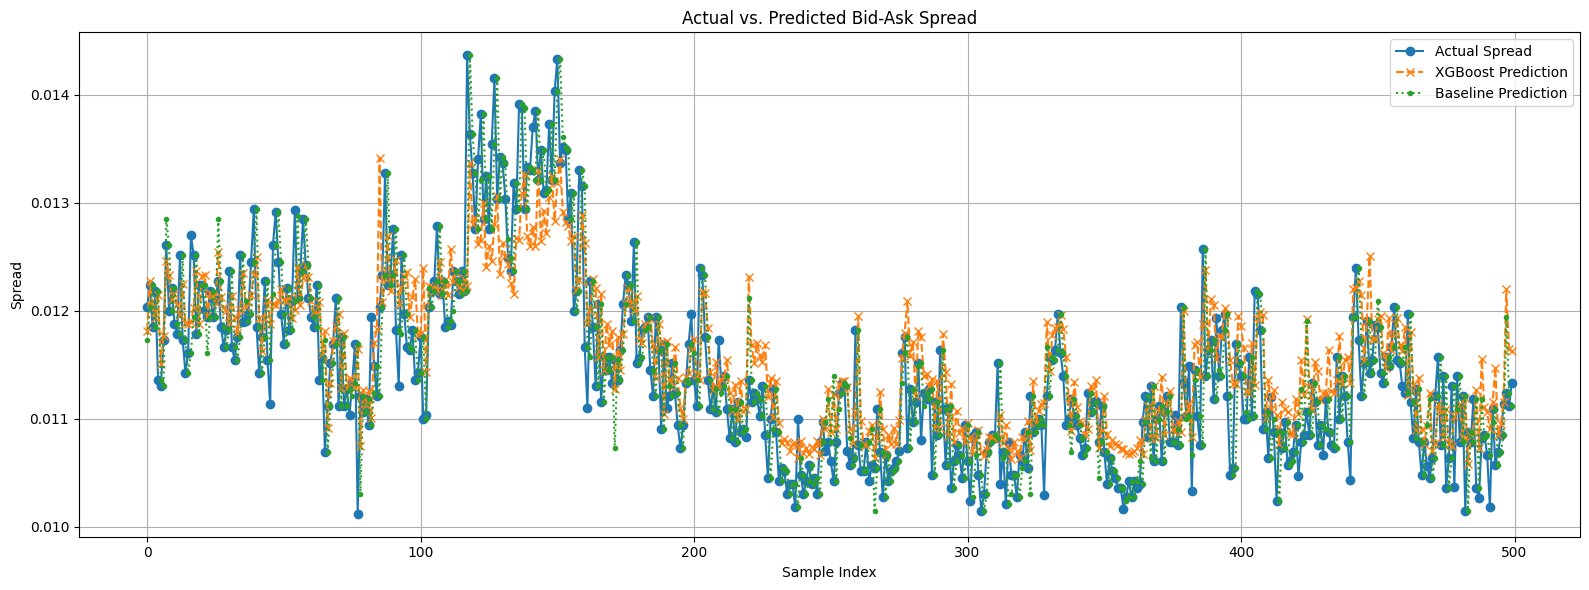

In [ ]:
import matplotlib.pyplot as plt

# Slice the first 500 samples
n = 500
y_true_500 = y_true.values[:n]
y_pred_best_500 = y_pred_best[:n]
baseline_pred_500 = baseline_pred[:n]

plt.figure(figsize=(16, 6))
plt.plot(y_true_500, label='Actual Spread', marker='o')
plt.plot(y_pred_best_500, label='XGBoost Prediction', marker='x', linestyle='--')
plt.plot(baseline_pred_500, label='Baseline Prediction', marker='.', linestyle=':')
plt.title('Actual vs. Predicted Bid-Ask Spread')
plt.xlabel('Sample Index')
plt.ylabel('Spread')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
import time

# --- Measure prediction time ---
start_time = time.time()

y_pred_best = best_model.predict(X_test_final)

end_time = time.time()
prediction_time = end_time - start_time

print(f"\nPrediction Time: {prediction_time:.6f} seconds")
print(f"Average Time per Sample: {prediction_time / len(X_test_final):.6f} seconds")



Prediction Time: 0.004000 seconds
Average Time per Sample: 0.000002 seconds


## Simple Mid-price Prediction model

In [ ]:
subset_snapshot_df['mid_price'] = (subset_snapshot_df['bid_price1'] + subset_snapshot_df['ask_price1']) / 2
feature_engineered_df = subset_snapshot_df.copy()

feature_engineered_df = feature_engineered_df[feature_engineered_df["stock_id"] == 50200].copy()
feature_engineered_df['bucket_id_330s'] = feature_engineered_df['seconds_in_bucket'] // 330
rv_df = feature_engineered_df.groupby(["time_id", "bucket_id_330s"])["log_return"].agg(
    lambda x: np.sqrt(np.sum(x**2))
).reset_index().rename(columns={"log_return": "realized_volatility"})

# Merge this instead of time_id-only version
feature_engineered_df = pd.merge(feature_engineered_df, rv_df, on=["time_id", "bucket_id_330s"], how="left")
feature_engineered_df = feature_engineered_df.groupby(['time_id', 'bucket_id_330s']).agg({
    "realized_volatility": "mean",
    "wap": "mean",
    "mid_price": "mean", 
    "spread_pct": "mean",
    "imbalance": "mean",
    "depth_ratio": "mean",
    "log_return": "mean",
    "bid_ask_spread": "mean"
}).reset_index()

feature_engineered_df = feature_engineered_df.drop(columns=[ 'time_id', 'bucket_id_330s'])
feature_engineered_df['mid_price_lead1'] = feature_engineered_df['mid_price'].shift(-1)
feature_engineered_df = feature_engineered_df.dropna(subset=['mid_price_lead1'])

MSE: 11.702078
MAE: 2.548185
RMSE: 3.420830
R²: 0.9786


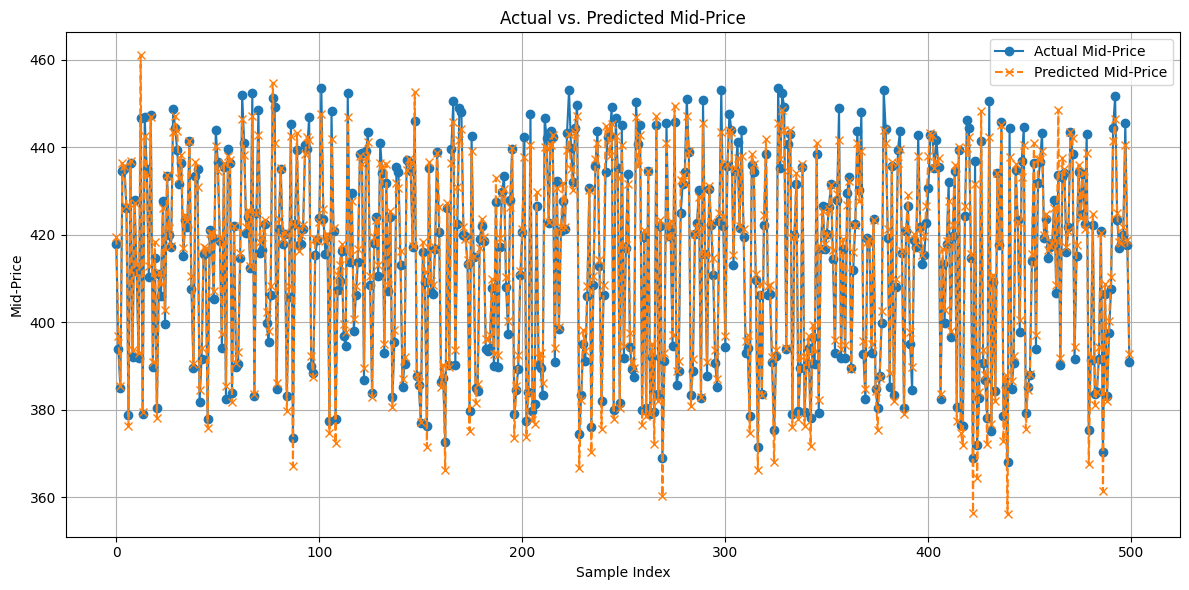

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Drop NA rows (if any)
model_df = feature_engineered_df.dropna(subset=['mid_price', 'wap', 'spread_pct', 'imbalance', 'depth_ratio', 'bid_ask_spread', 'realized_volatility'])

# Define features and target
features = [
    'spread_pct', 'imbalance', 'depth_ratio',
    'bid_ask_spread',
    'realized_volatility'
]
X = model_df[features]
y = model_df['mid_price_lead1']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit a simple linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict mid-price on test set
y_pred = model.predict(X_test)

joblib.dump(model, "mid_price_model.pkl")

# Evaluation
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse:.6f}")
print(f"MAE: {mae:.6f}")
print(f"RMSE: {rmse:.6f}")
print(f"R²: {r2:.4f}")

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(y_test.values[:500], label='Actual Mid-Price', marker='o')
plt.plot(y_pred[:500], label='Predicted Mid-Price', marker='x', linestyle='--')
plt.title("Actual vs. Predicted Mid-Price")
plt.xlabel("Sample Index")
plt.ylabel("Mid-Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Quoting Price

In [ ]:
import pandas as pd
import numpy as np
import joblib

# Features for each model
mid_price_features = [
    'spread_pct', 'imbalance', 'depth_ratio',
    'bid_ask_spread',
    'realized_volatility'
]

spread_features = ['predicted_volatility_lead1', 'spread_pct_scaled', 'realized_volatility_scaled', 'wap', 'imbalance', 'depth_ratio', 'log_return', 'bid_ask_spread']

# --- Load models ---
mid_model = joblib.load("mid_price_model.pkl")
spread_model = joblib.load("bid_ask_spread_model.pkl")

# --- Select one random row from your full feature set ---
random_row = feature_engineered_df.sample(1, random_state=42).copy()
next_index = random_row.index[0] + 1

# --- Simulate predicted_volatility_lead1 ---
random_row['predicted_volatility_lead1'] = random_row['realized_volatility']  # or insert actual prediction

# --- Standardize relevant features for spread model ---
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled_values = scaler.fit_transform(random_row[['spread_pct', 'realized_volatility', 'predicted_volatility_lead1']])
random_row[['spread_pct_scaled', 'realized_volatility_scaled', 'predicted_volatility_lead1']] = scaled_values

# --- Extract inputs ---
X_mid = random_row[mid_price_features]
X_spread = random_row[spread_features]

# --- Predict mid price and spread ---
pred_mid_price = mid_model.predict(X_mid)[0]
pred_spread = spread_model.predict(X_spread)[0]

# --- Compute quote ---
bid = pred_mid_price - pred_spread / 2
ask = pred_mid_price + pred_spread / 2

# --- Output ---
print("Quoting Price in next 330s Window:")
print(f"Predicted Mid Price (t+1): {pred_mid_price:.6f}")
print(f"Predicted Spread (t+1):    {pred_spread:.6f}")
print(f"→ Quoted Bid:               {bid:.6f}")
print(f"→ Quoted Ask:               {ask:.6f}")

if next_index in feature_engineered_df.index:
    actual_mid = feature_engineered_df.loc[next_index, 'mid_price']
    actual_spread = feature_engineered_df.loc[next_index, 'bid_ask_spread']
    real_bid = actual_mid - actual_spread / 2
    real_ask = actual_mid + actual_spread / 2

    print("\nReal Prices:")
    print(f"Actual Mid Price (t+1): {actual_mid:.6f}")
    print(f"Actual Spread (t+1):    {actual_spread:.6f}")
    print(f"→ Real Bid:              {real_bid:.6f}")
    print(f"→ Real Ask:              {real_ask:.6f}")

NameError: name 'feature_engineered_df' is not defined

## Trading at Predited Quoting Price, vs Actual Price

- This code simulates **cummulative PnL** trading at suggested bid/ask prices using predicted BAS and mid-price values.
- This strategy assumes that the market maker **is filled at their quoted prices** (buys at quoted bid and sells at quoted asks), and subsequently unwinds those positions at the real market bid and ask.
- The resulting PnL from each round-trip is accumulated to show overall profitability over time.

This approach, however, makes several critical, but simplifying assumptions:
1. It assumes **perfect and immediate execution** at the quoted prices without accounting for latency, slippage, partial fills or inventory constraints
2. It assumes that **both bid/ask legs are always filled** in each time window

PnL is calculated by:
1. The model predcts the mid-price and spread, then uses these to **compute a quoted bid & ask**
2. We assume the market maker is filled at both their bid & ask
3. To close the position (unwind), we assume market makers sell what they bought at **real market bid** and buy back what they sold at **real market ask**
--> Market makers unwid to **stay flat, reduce risk, and test quote robustness** in changing market directions.

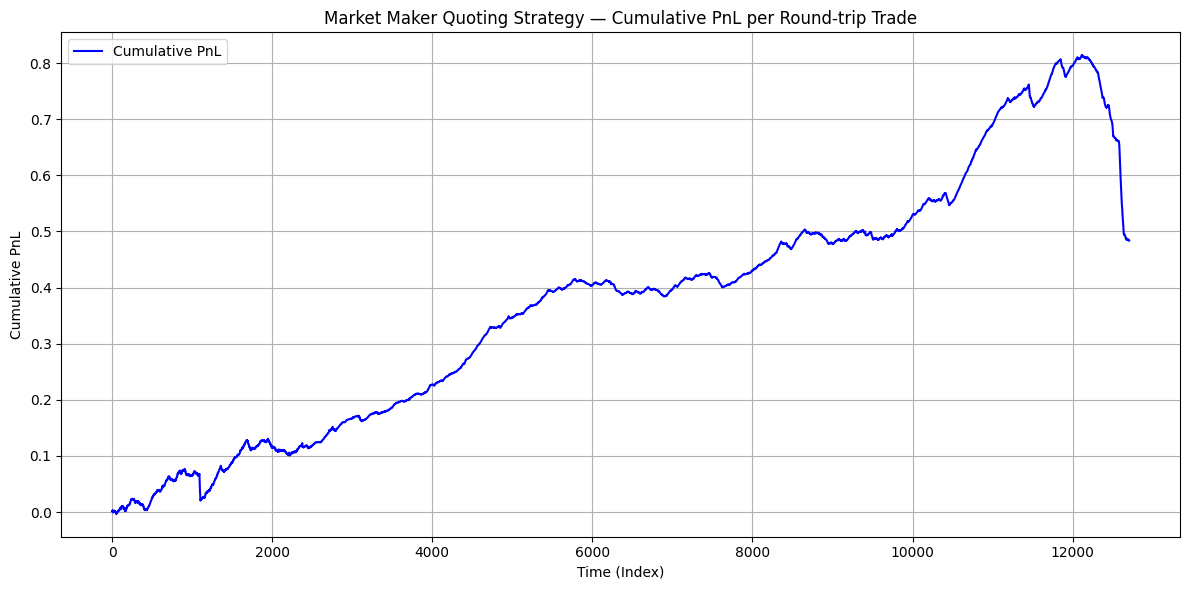

In [ ]:
# --- Define Features ---
mid_price_features = [
    'spread_pct', 'imbalance', 'depth_ratio',
    'bid_ask_spread',
    'realized_volatility'
]

spread_features = [
    'predicted_volatility_lead1', 'spread_pct_scaled', 'realized_volatility_scaled',
    'wap', 'imbalance', 'depth_ratio', 'log_return', 'bid_ask_spread'
]

# --- Load Models ---
mid_model = joblib.load("mid_price_model.pkl")
spread_model = joblib.load("bid_ask_spread_model.pkl")

# --- Prepare Data ---
df = feature_engineered_df.copy()
df['predicted_volatility_lead1'] = df['realized_volatility']

# Standardize spread-related features
scaler = StandardScaler()
scaled = scaler.fit_transform(df[['spread_pct', 'realized_volatility', 'predicted_volatility_lead1']])
df[['spread_pct_scaled', 'realized_volatility_scaled', 'predicted_volatility_lead1']] = scaled

# --- Predict mid price and spread ---
df['pred_mid_price'] = mid_model.predict(df[mid_price_features])
df['pred_spread'] = spread_model.predict(df[spread_features])

# --- Compute quoted prices ---
df['quoted_bid'] = df['pred_mid_price'] - df['pred_spread'] / 2
df['quoted_ask'] = df['pred_mid_price'] + df['pred_spread'] / 2

# --- Compute real market prices ---
df['real_bid'] = df['mid_price'] - df['bid_ask_spread'] / 2
df['real_ask'] = df['mid_price'] + df['bid_ask_spread'] / 2

# --- Market maker PnL: get filled at quoted prices, unwind at real bid/ask ---
df['pnl_bid_leg'] = df['real_bid'] - df['quoted_bid']      # Buy at quoted bid, sell at real bid
df['pnl_ask_leg'] = df['quoted_ask'] - df['real_ask']      # Sell at quoted ask, buy back at real ask
df['pnl_total'] = df['pnl_bid_leg'] + df['pnl_ask_leg']
df['cumulative_pnl'] = df['pnl_total'].cumsum()

# --- Plot cumulative PnL ---
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['cumulative_pnl'], label='Cumulative PnL', color='blue')
plt.xlabel("Time (Index)")
plt.ylabel("Cumulative PnL")
plt.title("Market Maker Quoting Strategy — Cumulative PnL per Round-trip Trade")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


We can measure how efficiently our model's quoting strategy capture value from the bid ask spread **by calculating "spread efficiency"**. This is the proportion of the real spread that we effectively earn after one round-trip trade.

From the graph we can see that:
1. The majority of our rolling spread efficiency values **hover just above 0**, which means our quoting strategy generally arns a small portion of the spread
2. Although its positive, we only retain around **0% - 5% of the actual spread**, which means that we have **low efficiency**
3. There are regions with extreme dips, meaning that our model fails to effectivaely quote in some conditions

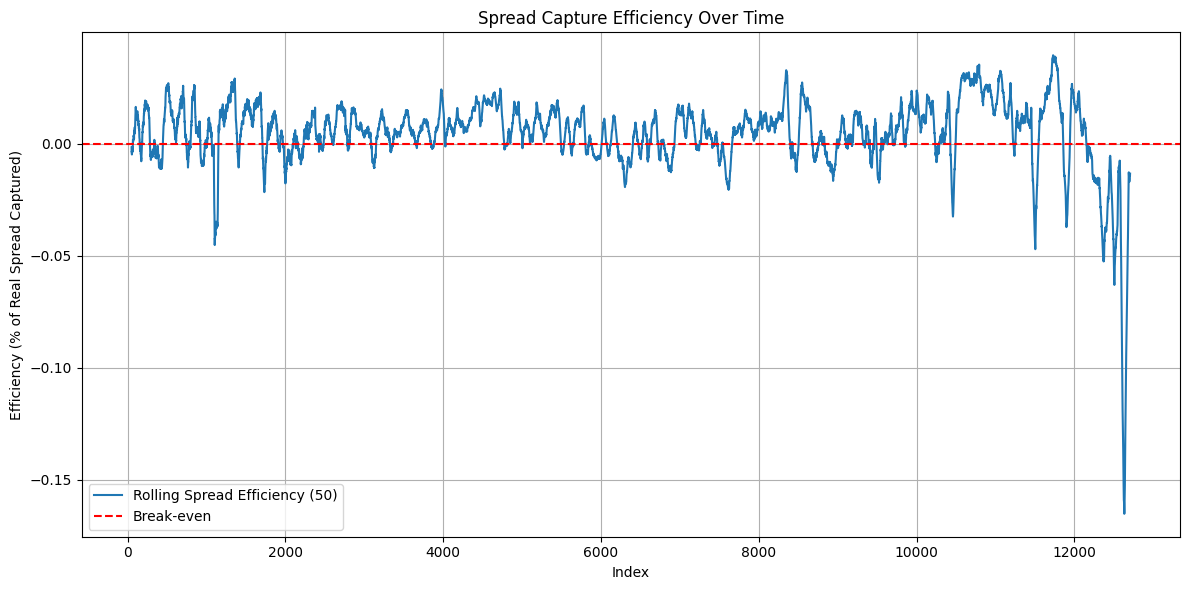

In [ ]:
# --- Spread metrics ---
df['quoted_spread'] = df['quoted_ask'] - df['quoted_bid']
df['real_spread'] = df['real_ask'] - df['real_bid']

# --- Captured Spread ---
df['captured_spread'] = (df['real_bid'] - df['quoted_bid']) + (df['quoted_ask'] - df['real_ask'])

# --- Spread Efficiency ---
df['spread_efficiency'] = df['captured_spread'] / df['real_spread']
df['spread_efficiency'] = df['spread_efficiency'].clip(lower=-1, upper=2)

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['spread_efficiency'].rolling(50).mean(), label='Rolling Spread Efficiency (50)')
plt.axhline(0.0, color='red', linestyle='--', label='Break-even')
plt.title("Spread Capture Efficiency Over Time")
plt.xlabel("Index")
plt.ylabel("Efficiency (% of Real Spread Captured)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Interstock Correlation

In [9]:
# Set path to local data directory
folder_path = "data"
feature_path = os.path.join(folder_path, "order_book_feature.parquet")
target_path = os.path.join(folder_path, "order_book_target.parquet")

# Load and combine parquet files
feature_df = pd.read_parquet(feature_path, engine='pyarrow')
target_df = pd.read_parquet(target_path, engine='pyarrow')
combined_df = pd.concat([feature_df, target_df], axis=0)
combined_df = combined_df.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

# Filter one stock for now
df_spy = combined_df[combined_df["stock_id"] == 50200].copy()
df_qqq = combined_df[combined_df["stock_id"] == 104919].copy()
df_nflx = combined_df[combined_df["stock_id"] == 22771].copy()

# Step 1: Compute snapshot features
snapshot_features_df_spy = util.create_snapshot_features(df_spy)
snapshot_features_df_spy = snapshot_features_df_spy.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

subset_time_ids_spy = snapshot_features_df_spy['time_id'].unique()
subset_snapshot_df_spy = snapshot_features_df_spy[snapshot_features_df_spy['time_id'].isin(subset_time_ids_spy)].copy()

snapshot_features_df_qqq = util.create_snapshot_features(df_qqq)
snapshot_features_df_qqq = snapshot_features_df_qqq.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

subset_time_ids_qqq = snapshot_features_df_qqq['time_id'].unique()
subset_snapshot_df_qqq = snapshot_features_df_qqq[snapshot_features_df_qqq['time_id'].isin(subset_time_ids_qqq)].copy()

snapshot_features_df_nflx = util.create_snapshot_features(df_nflx)
snapshot_features_df_nflx = snapshot_features_df_nflx.sort_values(by=['stock_id', 'time_id', 'seconds_in_bucket']).reset_index(drop=True)

subset_time_ids_nflx = snapshot_features_df_nflx['time_id'].unique()
subset_snapshot_df_nflx = snapshot_features_df_nflx[snapshot_features_df_nflx['time_id'].isin(subset_time_ids_nflx)].copy()

### QQQ

In [ ]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model

# --- Load model and scaler ---
model = load_model("out/lstm/moe_full.h5", custom_objects={"mse": "mse"})
scaler = joblib.load("out/lstm/moe_scalers_full.pkl")
x_scaler = scaler["x_scaler"]

# --- Define features used by LSTM ---
basic_features = ["wap", "spread_pct", "imbalance",
                  "depth_ratio", "log_return", "log_wap_change",
                  "rolling_std_logret", "spread_zscore", "volume_imbalance"]

# --- Group by time_id and bucket into 330s chunks ---
subset_snapshot_df_qqq["bucket_id_330s"] = subset_snapshot_df_qqq["seconds_in_bucket"] // 330

# Collect predictions
predictions = []

# Iterate over time_id + bucket_id_330s
grouped = subset_snapshot_df_qqq.groupby(['time_id', 'bucket_id_330s'])

for (time_id, bucket), group in grouped:
    if len(group) < 330:
        continue  # Skip if not enough steps for LSTM

    X = group[basic_features].values[-330:]  # Last 330 rows
    X_scaled = x_scaler.transform(X)
    X_reshaped = X_scaled.reshape(1, 330, len(basic_features))

    y_pred = model.predict(X_reshaped, verbose=0)[0][0]

    predictions.append({
        'time_id': time_id,
        'bucket_id_330s': bucket,
        'predicted_value': y_pred
    })

# --- Create DataFrame of results ---
pred_df = pd.DataFrame(predictions)
pred_df.to_csv("predictions_qqq.csv", index=False)
print(pred_df.head(10))


In [ ]:
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Load trained model ---
model = joblib.load("bid_ask_spread_model.pkl")

def evaluate_on_stock(pred_path, snapshot_df, label):
    if not os.path.exists(pred_path):
        raise FileNotFoundError(f"{pred_path} not found.")
    
    pred_df = pd.read_csv(pred_path).rename(columns={"predicted_value": "predicted_volatility_lead1"})
    pred_df['predicted_volatility_lead1'] = pred_df['predicted_volatility_lead1'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else x)
    pred_df['predicted_volatility_lead1'] = pd.to_numeric(pred_df['predicted_volatility_lead1'], errors='coerce')
    snapshot_df = snapshot_df.copy()
    snapshot_df['log_return_squared'] = snapshot_df['log_return'] ** 2
    rv_df = snapshot_df.groupby("time_id")['log_return_squared'].sum().reset_index()
    rv_df['realized_volatility'] = np.sqrt(rv_df['log_return_squared'])
    
    snapshot_df['bucket_id_330s'] = snapshot_df['seconds_in_bucket'] // 330
    agg_df = snapshot_df.groupby(['time_id', 'bucket_id_330s']).agg({
        "wap": "mean",
        "spread_pct": "mean",
        "imbalance": "mean",
        "depth_ratio": "mean",
        "log_return": "mean",
        "bid_ask_spread": "mean"
    }).reset_index()

    agg_df['bid_ask_spread_lead1'] = agg_df.groupby('time_id')['bid_ask_spread'].shift(-1)
    agg_df = agg_df.dropna(subset=['bid_ask_spread_lead1']).reset_index(drop=True)
    agg_df = agg_df.merge(rv_df[['time_id', 'realized_volatility']], on='time_id', how='left')
    
    merged_df = pd.merge(pred_df, agg_df, on=['time_id', 'bucket_id_330s'], how='inner')

    X = merged_df.drop(columns=["time_id", "bucket_id_330s"])
    y = merged_df["bid_ask_spread_lead1"]

    cutoff = int(len(merged_df) * 0.8)
    X_train = X.iloc[:cutoff].copy()
    X_test = X.iloc[cutoff:].copy()
    y_test = y.iloc[cutoff:]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[['spread_pct', 'realized_volatility']])
    X_test_scaled = scaler.transform(X_test[['spread_pct', 'realized_volatility']])
    X_train[['spread_pct_scaled', 'realized_volatility_scaled']] = X_train_scaled
    X_test[['spread_pct_scaled', 'realized_volatility_scaled']] = X_test_scaled

    feature_cols = ['predicted_volatility_lead1', 'spread_pct_scaled', 'realized_volatility_scaled',
                    'wap', 'imbalance', 'depth_ratio', 'log_return', 'bid_ask_spread']
    X_test_final = X_test[feature_cols]
    y_test_final = y_test

    y_pred = model.predict(X_test_final)

    metrics = {
        "label": label.upper(),
        "mse": mean_squared_error(y_test_final, y_pred),
        "mae": mean_absolute_error(y_test_final, y_pred),
        "rmse": np.sqrt(mean_squared_error(y_test_final, y_pred)),
        "r2": r2_score(y_test_final, y_pred)
    }

    comparison_df = pd.DataFrame({
        "time_id": merged_df.loc[y_test_final.index, "time_id"].values,
        "bucket_id_330s": merged_df.loc[y_test_final.index, "bucket_id_330s"].values,
        "actual_bid_ask_spread": y_test_final.values,
        "predicted_bid_ask_spread": y_pred
    })

    return metrics, comparison_df

# --- Evaluate both stocks ---
metrics_qqq, df_qqq = evaluate_on_stock("predictions_qqq.csv", subset_snapshot_df_qqq, "qqq")
metrics_spy, df_spy = evaluate_on_stock("predictions_spy.csv", subset_snapshot_df_spy, "spy")


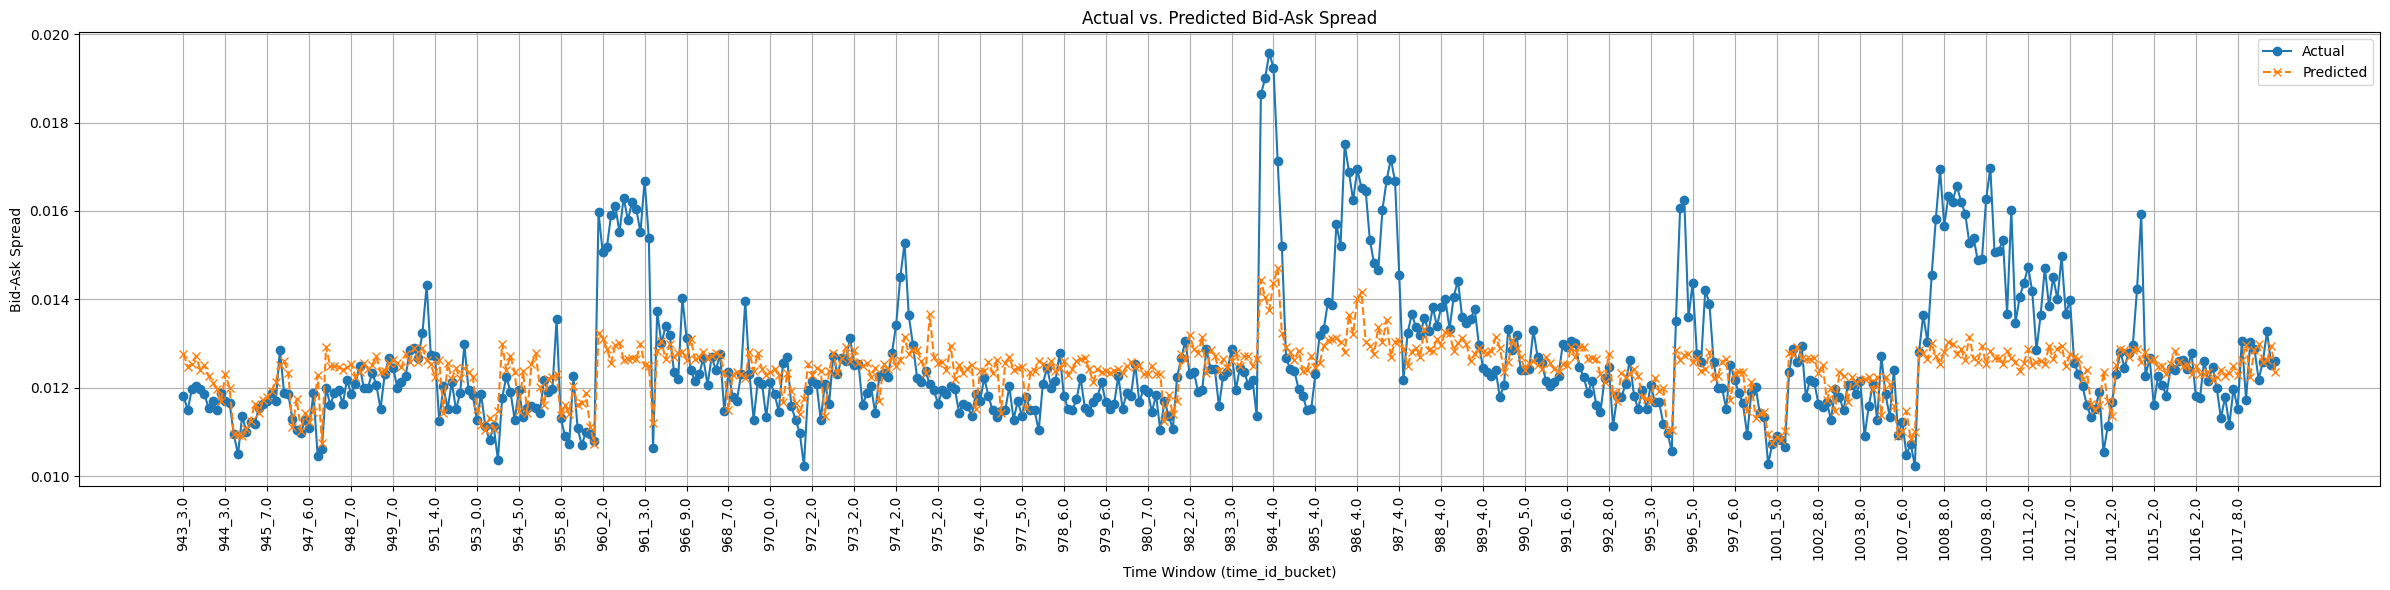

In [17]:
import matplotlib.pyplot as plt

# Slice first 500 rows
subset = df_qqq.head(500).copy()

if 'window_label' not in subset.columns:
    subset['window_label'] = subset['time_id'].astype(str) + '_' + subset['bucket_id_330s'].astype(str)

# Plot
plt.figure(figsize=(24, 6))
plt.plot(subset['window_label'], subset['actual_bid_ask_spread'], label='Actual', marker='o')
plt.plot(subset['window_label'], subset['predicted_bid_ask_spread'], label='Predicted', marker='x', linestyle='--')

plt.title("Actual vs. Predicted Bid-Ask Spread")
plt.xlabel("Time Window (time_id_bucket)")
plt.ylabel("Bid-Ask Spread")
plt.xticks(ticks=np.arange(0, len(subset), 10), labels=subset['window_label'][::10], rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### NFLX

In [32]:
import src.util

seq_df = util.generate_tick_sequences(snapshot_features_df_nflx, basic_features)
seq_df

,X,y,time_id,start_time
0,"[[528.2709042884463, 0.0006434397520042998, -0...",0.000286,6,1800.0
1,"[[528.4999519545498, 0.0006245682423615474, 0....",0.000312,6,1802.0
2,"[[528.3298282697889, 0.0006814181055035786, 0....",0.000438,6,1805.0
3,"[[528.2703555706239, 0.0006814181055035786, -0...",0.000561,6,1807.0
4,"[[528.2632687790464, 0.0006624835549578171, -0...",0.000404,6,1810.0
...,...,...,...,...
514139,"[[632.9243618140761, 0.0004266784654956238, 0....",0.000356,1199,3233.0
514140,"[[632.7462685601454, 0.00030027419727944143, -...",0.000340,1199,3238.0
514141,"[[632.7371337764885, 0.0001422306504805044, -0...",0.000386,1199,3244.0
514142,"[[632.716171277244, 7.902701921275465e-05, 0.8...",0.000484,1199,3249.0


In [ ]:
util.


In [ ]:
import pandas as pd
import numpy as np
import joblib
from tensorflow.keras.models import load_model

# --- Load model and scaler ---
model = load_model("out/lstm/moe_full.h5", custom_objects={"mse": "mse"})
scaler = joblib.load("out/lstm/moe_scalers_full.pkl")

# --- Define features used by LSTM ---
basic_features = ["wap", "spread_pct", "imbalance",
                  "depth_ratio", "log_return", "log_wap_change",
                  "rolling_std_logret", "spread_zscore", "volume_imbalance"]

val_df, 


In [11]:
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --- Load trained model ---
model = joblib.load("bid_ask_spread_model.pkl")

def evaluate_on_stock(pred_path, snapshot_df, label):
    if not os.path.exists(pred_path):
        raise FileNotFoundError(f"{pred_path} not found.")
    
    pred_df = pd.read_csv(pred_path).rename(columns={"predicted_value": "predicted_volatility_lead1"})
    pred_df['predicted_volatility_lead1'] = pred_df['predicted_volatility_lead1'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else x)
    pred_df['predicted_volatility_lead1'] = pd.to_numeric(pred_df['predicted_volatility_lead1'], errors='coerce')
    snapshot_df = snapshot_df.copy()
    snapshot_df['log_return_squared'] = snapshot_df['log_return'] ** 2
    rv_df = snapshot_df.groupby("time_id")['log_return_squared'].sum().reset_index()
    rv_df['realized_volatility'] = np.sqrt(rv_df['log_return_squared'])
    
    snapshot_df['bucket_id_330s'] = snapshot_df['seconds_in_bucket'] // 330
    agg_df = snapshot_df.groupby(['time_id', 'bucket_id_330s']).agg({
        "wap": "mean",
        "spread_pct": "mean",
        "imbalance": "mean",
        "depth_ratio": "mean",
        "log_return": "mean",
        "bid_ask_spread": "mean"
    }).reset_index()

    agg_df['bid_ask_spread_lead1'] = agg_df.groupby('time_id')['bid_ask_spread'].shift(-1)
    agg_df = agg_df.dropna(subset=['bid_ask_spread_lead1']).reset_index(drop=True)
    agg_df = agg_df.merge(rv_df[['time_id', 'realized_volatility']], on='time_id', how='left')
    
    merged_df = pd.merge(pred_df, agg_df, on=['time_id', 'bucket_id_330s'], how='inner')

    X = merged_df.drop(columns=["time_id", "bucket_id_330s"])
    y = merged_df["bid_ask_spread_lead1"]

    cutoff = int(len(merged_df) * 0.8)
    X_train = X.iloc[:cutoff].copy()
    X_test = X.iloc[cutoff:].copy()
    y_test = y.iloc[cutoff:]

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train[['spread_pct', 'realized_volatility']])
    X_test_scaled = scaler.transform(X_test[['spread_pct', 'realized_volatility']])
    X_train[['spread_pct_scaled', 'realized_volatility_scaled']] = X_train_scaled
    X_test[['spread_pct_scaled', 'realized_volatility_scaled']] = X_test_scaled

    feature_cols = ['predicted_volatility_lead1', 'spread_pct_scaled', 'realized_volatility_scaled',
                    'wap', 'imbalance', 'depth_ratio', 'log_return', 'bid_ask_spread']
    X_test_final = X_test[feature_cols]
    y_test_final = y_test

    y_pred = model.predict(X_test_final)

    metrics = {
        "label": label.upper(),
        "mse": mean_squared_error(y_test_final, y_pred),
        "mae": mean_absolute_error(y_test_final, y_pred),
        "rmse": np.sqrt(mean_squared_error(y_test_final, y_pred)),
        "r2": r2_score(y_test_final, y_pred)
    }

    comparison_df = pd.DataFrame({
        "time_id": merged_df.loc[y_test_final.index, "time_id"].values,
        "bucket_id_330s": merged_df.loc[y_test_final.index, "bucket_id_330s"].values,
        "actual_bid_ask_spread": y_test_final.values,
        "predicted_bid_ask_spread": y_pred
    })

    return metrics, comparison_df

# --- Evaluate both stocks ---
metrics_qqq, df_qqq = evaluate_on_stock("predictions_qqq.csv", subset_snapshot_df_qqq, "qqq")
metrics_spy, df_spy = evaluate_on_stock("predictions_spy.csv", subset_snapshot_df_spy, "spy")
metrics_nflx, df_nflx = evaluate_on_stock("predictions_nflx.csv", subset_snapshot_df_nflx, "spy")

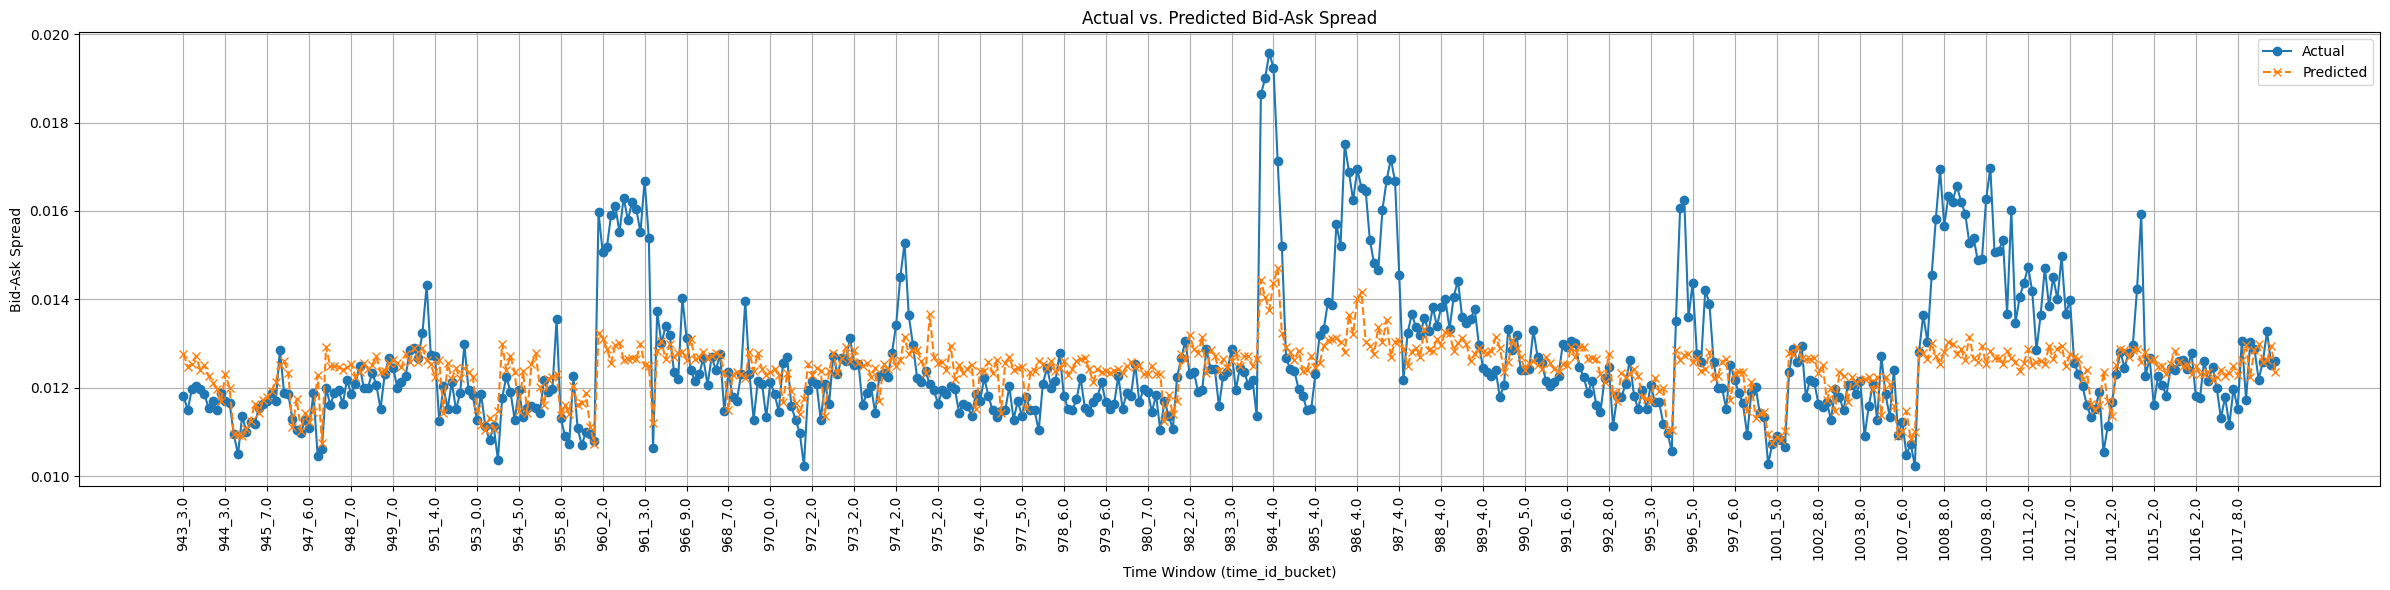

In [16]:
import matplotlib.pyplot as plt

# Slice first 500 rows
subset = df_qqq.head(500).copy()

if 'window_label' not in subset.columns:
    subset['window_label'] = subset['time_id'].astype(str) + '_' + subset['bucket_id_330s'].astype(str)

# Plot
plt.figure(figsize=(24, 6))
plt.plot(subset['window_label'], subset['actual_bid_ask_spread'], label='Actual', marker='o')
plt.plot(subset['window_label'], subset['predicted_bid_ask_spread'], label='Predicted', marker='x', linestyle='--')

plt.title("Actual vs. Predicted Bid-Ask Spread")
plt.xlabel("Time Window (time_id_bucket)")
plt.ylabel("Bid-Ask Spread")
plt.xticks(ticks=np.arange(0, len(subset), 10), labels=subset['window_label'][::10], rotation=90)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Evalutation

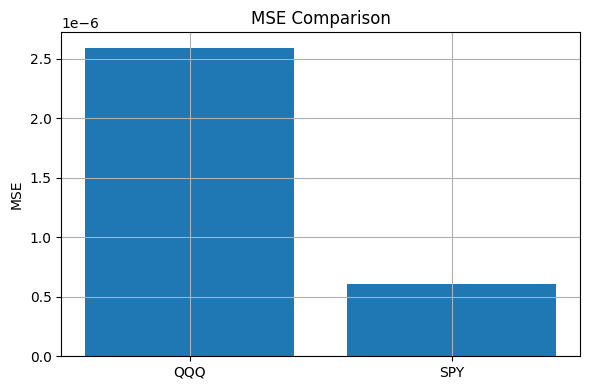

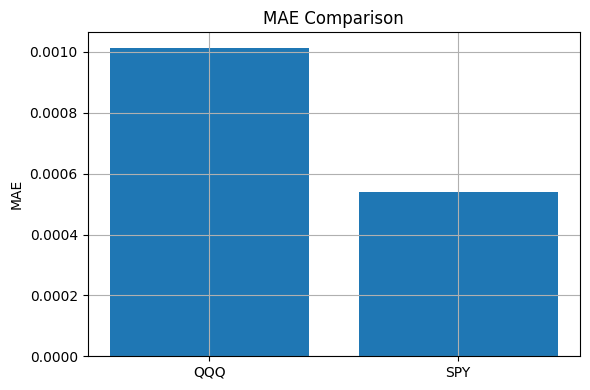

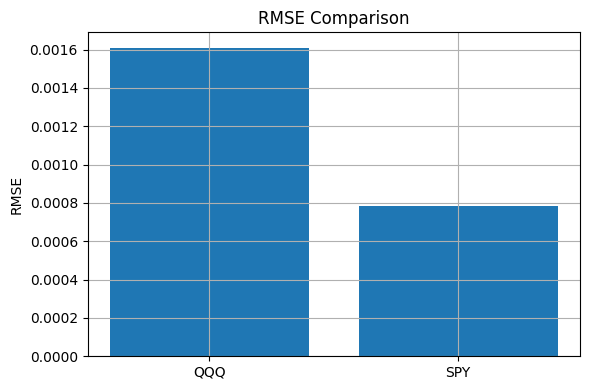

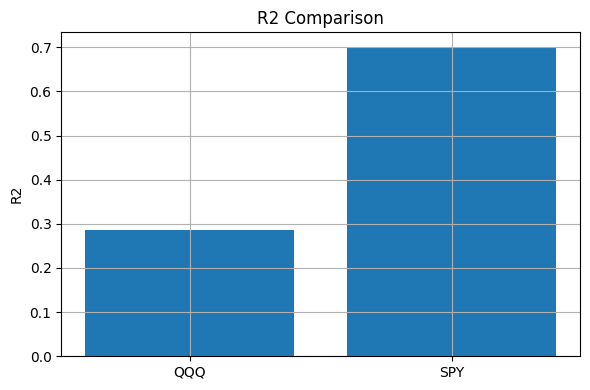

In [ ]:
metrics_df = pd.DataFrame([metrics_qqq, metrics_spy])

# --- Plot comparison ---
metrics_to_plot = ['mse', 'mae', 'rmse', 'r2']
for metric in metrics_to_plot:
    plt.figure(figsize=(6, 4))
    plt.bar(metrics_df['label'], metrics_df[metric])
    plt.title(f'{metric.upper()} Comparison')
    plt.ylabel(metric.upper())
    plt.grid(True)
    plt.tight_layout()
    plt.show()